In [303]:
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score
from torch.utils.data import random_split
from matplotlib import pyplot as plt
import shap
from sklearn.model_selection import train_test_split

In [2]:
train_series = pd.read_csv('train.csv',index_col=['sequence','subject','step'])[['sensor_04']].reset_index()
train_labels = pd.read_csv('train_labels.csv', index_col=['sequence'])

In [3]:
train_series

,sequence,subject,step,sensor_04
0,0,47,0,-1.004660
1,0,47,1,0.162495
2,0,47,2,0.473678
3,0,47,3,-0.563287
4,0,47,4,0.398579
...,...,...,...,...
1558075,25967,327,55,-0.930698
1558076,25967,327,56,0.775324
1558077,25967,327,57,0.308861
1558078,25967,327,58,-0.460541


In [4]:
train_series['sensor_04_square'] = np.square(train_series['sensor_04'])
train_series['sensor_04_diff'] = train_series['sensor_04'].diff()
train_series.loc[train_series['step']==0, 'sensor_04_diff'] = 0.0
pd.set_option('display.max_row',100)
train_series.head(100)

,sequence,subject,step,sensor_04,sensor_04_square,sensor_04_diff
0,0,47,0,-1.004660,1.009341,0.000000
1,0,47,1,0.162495,0.026405,1.167155
2,0,47,2,0.473678,0.224371,0.311183
3,0,47,3,-0.563287,0.317292,-1.036965
4,0,47,4,0.398579,0.158865,0.961866
5,0,47,5,0.469736,0.220652,0.071157
6,0,47,6,-0.596964,0.356366,-1.066700
7,0,47,7,-0.059983,0.003598,0.536981
8,0,47,8,-0.071718,0.005143,-0.011735
9,0,47,9,-0.755221,0.570358,-0.683503


In [5]:
scs = {}
for col in train_series.columns[3:]:
    sc = StandardScaler()
    train_series[col] = sc.fit_transform(train_series[col].values.reshape(-1,1))
    scs[col] = sc

In [6]:
train_series

,sequence,subject,step,sensor_04,sensor_04_square,sensor_04_diff
0,0,47,0,-0.595617,-0.144085,-0.000019
1,0,47,1,0.097598,-0.221669,0.576487
2,0,47,2,0.282421,-0.206043,0.153687
3,0,47,3,-0.333470,-0.198709,-0.512218
4,0,47,4,0.237816,-0.211214,0.475086
...,...,...,...,...,...,...
1558075,25967,327,55,-0.551688,-0.155383,-0.304236
1558076,25967,327,56,0.461579,-0.176305,0.842655
1558077,25967,327,57,0.184530,-0.216223,-0.230424
1558078,25967,327,58,-0.272446,-0.207012,-0.380058


In [7]:
tmp = train_series.groupby(['subject','step']).agg({'sensor_04':'mean'}).to_dict()['sensor_04']
train_series['sensor_04_subject_mean'] = pd.Series(zip(train_series['subject'], train_series['step'])).map(tmp)

In [8]:
tmp = train_series.groupby(['subject','step']).agg({'sensor_04_square':'mean'}).to_dict()['sensor_04_square']
train_series['sensor_04_square_subject_mean'] = pd.Series(zip(train_series['subject'], train_series['step'])).map(tmp)

In [9]:
tmp = train_series.groupby(['subject','step']).agg({'sensor_04_diff':'mean'}).to_dict()['sensor_04_diff']
train_series['sensor_04_diff_subject_mean'] = pd.Series(zip(train_series['subject'], train_series['step'])).map(tmp)
train_series

,sequence,subject,step,sensor_04,sensor_04_square,sensor_04_diff,sensor_04_subject_mean,sensor_04_square_subject_mean,sensor_04_diff_subject_mean
0,0,47,0,-0.595617,-0.144085,-0.000019,-0.126449,0.039625,-0.000019
1,0,47,1,0.097598,-0.221669,0.576487,0.004183,0.201179,0.108620
2,0,47,2,0.282421,-0.206043,0.153687,0.065081,0.223544,0.050627
3,0,47,3,-0.333470,-0.198709,-0.512218,-0.048740,0.090860,-0.094677
4,0,47,4,0.237816,-0.211214,0.475086,0.070759,-0.052421,0.099361
...,...,...,...,...,...,...,...,...,...
1558075,25967,327,55,-0.551688,-0.155383,-0.304236,-0.087041,-0.197218,-0.064610
1558076,25967,327,56,0.461579,-0.176305,0.842655,-0.073663,-0.205267,0.011107
1558077,25967,327,57,0.184530,-0.216223,-0.230424,-0.017011,-0.213320,0.047095
1558078,25967,327,58,-0.272446,-0.207012,-0.380058,0.039722,-0.205369,0.047163


<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>


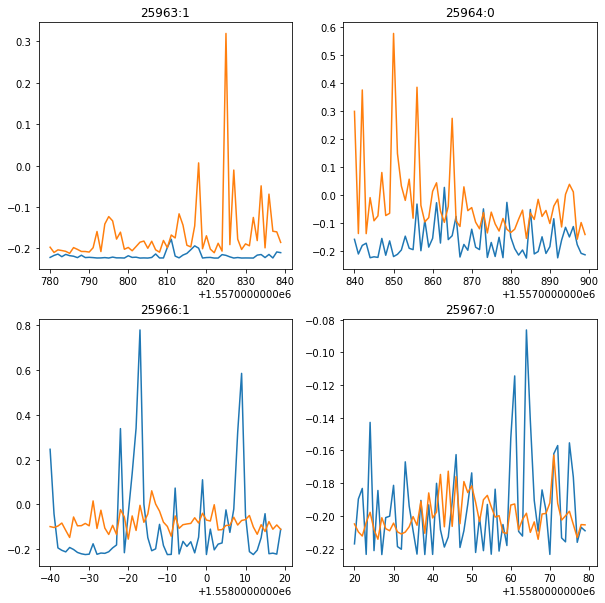

In [10]:
seqs = [25963,25964,25966,25967]
fig, axes = plt.subplots(2,2,figsize=(10,10))
axes = axes.reshape(-1)
for i, seq in enumerate(seqs):
    ax = axes[i]
    print(type(ax))
    ax.plot(train_series.loc[train_series['sequence']==seq, 'sensor_04_square']);
    ax.plot(train_series.loc[train_series['sequence']==seq, 'sensor_04_square_subject_mean']);
    ax.set_title(str(seq) + ':' + str(train_labels.loc[seq].values[0]));

<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>


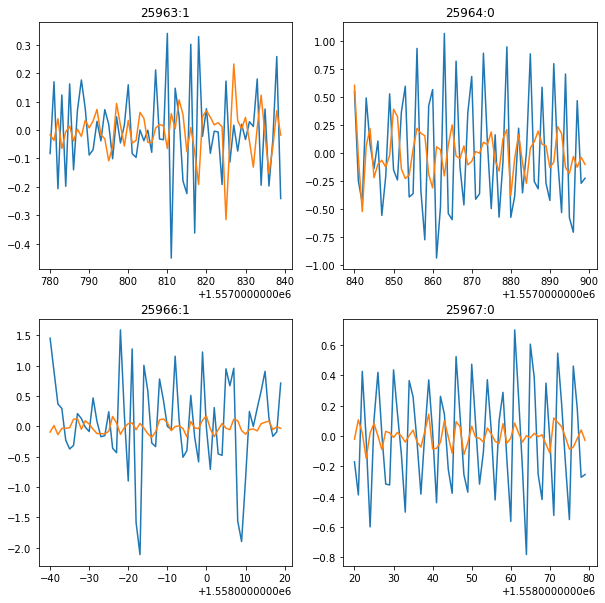

In [11]:
seqs = [25963,25964,25966,25967]
fig, axes = plt.subplots(2,2,figsize=(10,10))
axes = axes.reshape(-1)
for i, seq in enumerate(seqs):
    ax = axes[i]
    print(type(ax))
    ax.plot(train_series.loc[train_series['sequence']==seq, 'sensor_04']);
    ax.plot(train_series.loc[train_series['sequence']==seq, 'sensor_04_subject_mean']);
    ax.set_title(str(seq) + ':' + str(train_labels.loc[seq].values[0]));

<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>


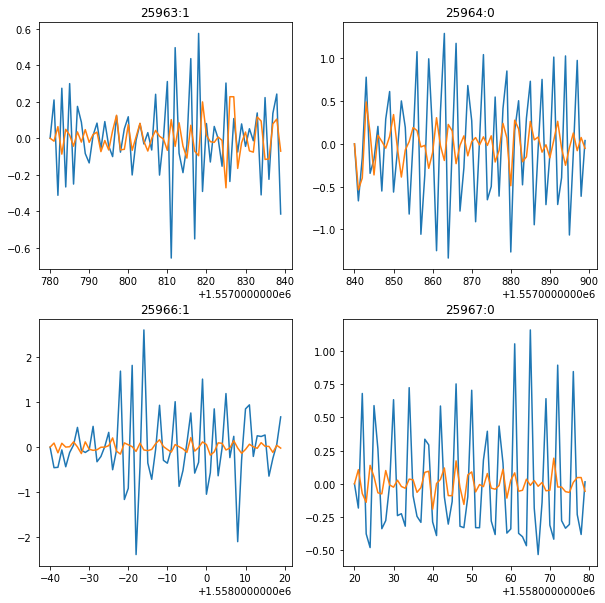

In [12]:
seqs = [25963,25964,25966,25967]
fig, axes = plt.subplots(2,2,figsize=(10,10))
axes = axes.reshape(-1)
for i, seq in enumerate(seqs):
    ax = axes[i]
    print(type(ax))
    ax.plot(train_series.loc[train_series['sequence']==seq, 'sensor_04_diff']);
    ax.plot(train_series.loc[train_series['sequence']==seq, 'sensor_04_diff_subject_mean']);
    ax.set_title(str(seq) + ':' + str(train_labels.loc[seq].values[0]));

### let's see if any of this is useful

In [13]:
train_series

,sequence,subject,step,sensor_04,sensor_04_square,sensor_04_diff,sensor_04_subject_mean,sensor_04_square_subject_mean,sensor_04_diff_subject_mean
0,0,47,0,-0.595617,-0.144085,-0.000019,-0.126449,0.039625,-0.000019
1,0,47,1,0.097598,-0.221669,0.576487,0.004183,0.201179,0.108620
2,0,47,2,0.282421,-0.206043,0.153687,0.065081,0.223544,0.050627
3,0,47,3,-0.333470,-0.198709,-0.512218,-0.048740,0.090860,-0.094677
4,0,47,4,0.237816,-0.211214,0.475086,0.070759,-0.052421,0.099361
...,...,...,...,...,...,...,...,...,...
1558075,25967,327,55,-0.551688,-0.155383,-0.304236,-0.087041,-0.197218,-0.064610
1558076,25967,327,56,0.461579,-0.176305,0.842655,-0.073663,-0.205267,0.011107
1558077,25967,327,57,0.184530,-0.216223,-0.230424,-0.017011,-0.213320,0.047095
1558078,25967,327,58,-0.272446,-0.207012,-0.380058,0.039722,-0.205369,0.047163


In [14]:
train_series.shape

(1558080, 9)

In [15]:
class MyDataset(Dataset):
    def __init__(self, series, labels=None):
        self.X = series.drop(columns=['sequence','subject','step']).values
        self.X = self.X.reshape(-1,60,series.shape[1]-3).transpose([0,2,1]).copy()
        if labels is None:
            self.y = None
        else:
            self.y = labels['state'].values
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        ''' input tensor shape is N*C*L '''
        X = self.X[idx]
        if self.y is None:
            y = -1
        else:
            y = self.y[idx]
        return (torch.tensor(X, dtype=torch.float32), torch.tensor(y))

In [16]:
mydataset = MyDataset(train_series, train_labels)

In [17]:
mydataset[0]

(tensor([[-5.9562e-01,  9.7598e-02,  2.8242e-01, -3.3347e-01,  2.3782e-01,
           2.8008e-01, -3.5347e-01, -3.4540e-02, -4.1510e-02, -4.4747e-01,
           2.3069e-01,  5.7832e-01, -1.7433e-01, -2.0142e-01,  4.0458e-01,
           9.6126e-02, -4.1663e-01,  1.5892e-01,  1.7584e-01, -5.1042e-01,
          -2.7061e-02,  3.8333e-01, -1.8909e-01, -1.6634e-01,  3.3735e-01,
          -7.6606e-03, -4.6181e-01,  2.5079e-01,  4.7423e-03,  2.2052e-01,
           2.9747e-01, -4.7099e-01, -2.8151e-01,  3.7852e-01, -4.3398e-02,
          -3.5497e-01,  3.6708e-01,  3.5457e-01, -3.6485e-01, -4.9210e-01,
           3.4629e-01,  2.8768e-01, -3.6800e-01,  1.8210e-01,  3.0169e-01,
          -4.9477e-01, -1.8027e-02,  4.2741e-01, -2.3753e-01, -4.7721e-01,
           3.9393e-01,  3.8903e-01, -5.6331e-01,  3.0763e-03,  5.7171e-01,
          -3.4340e-01, -9.5182e-01,  1.0990e-01,  8.7194e-02, -7.0078e-01],
         [-1.4408e-01, -2.2167e-01, -2.0604e-01, -1.9871e-01, -2.1121e-01,
          -2.0634e-01, -

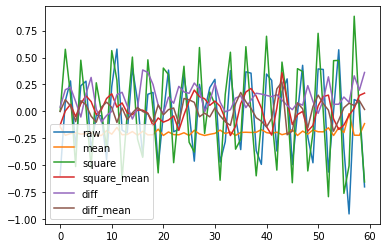

In [18]:
plt.plot(mydataset[0][0].T, label=['raw','mean','square','square_mean','diff','diff_mean']);
plt.legend()

In [19]:
mydataset[0][0].shape

torch.Size([6, 60])

In [20]:
class MyModel(nn.Module):
    def __init__(self, input_channel):
        super(MyModel, self).__init__()
        torch.manual_seed(123)
        self.conv1d_1 = nn.Conv1d(input_channel, 12, 5, padding='valid')
#         self.maxpool_1 = nn.MaxPool1d(5)
        self.maxpool_1 = nn.Conv1d(12, 12, 5, groups=12, stride=5, padding='valid')
        self.conv1d_2 = nn.Conv1d(12, 24, 5, padding='valid')
#         self.maxpool_2 = nn.MaxPool1d(7)
        self.maxpool_2 = nn.Conv1d(24, 24, 7, groups=24, stride=7, padding='valid')
        self.fc1 = nn.Linear(24, 12)
        self.fc2 = nn.Linear(12, 6)
        self.fc3 = nn.Linear(6,2)
        self.dropout = nn.Dropout(p=0.2)
    
    def forward(self, X):
        ''' input shape (N,C,L) '''
        X = F.relu(self.conv1d_1(X))
        X = self.dropout(X)
        X = self.maxpool_1(X)
        X = F.relu(self.conv1d_2(X))
        X = self.dropout(X)
        X = self.maxpool_2(X)
        
        X = torch.squeeze(X, dim=2)
        X = self.dropout(X)
        X = F.relu(self.fc1(X))
        X = self.dropout(X)
        X = F.relu(self.fc2(X))
        output = F.log_softmax(self.fc3(X), dim=1)
        
        return output

In [21]:
model = MyModel(6)

In [22]:
def evaluate(test_loader):
    model.eval()
    criteria = nn.NLLLoss()
    with torch.no_grad():
        X, y = next(iter(test_loader))
        output = model(X)
        score = roc_auc_score(y.detach().numpy(), output.detach().numpy()[:,1])
        loss = criteria(output, y)
    return score, loss

In [23]:
def train(dataset, epoches=200, batch_size=64):
    torch.manual_seed(123)
    N = len(dataset)
    n1 = int(N*0.9)
    n2 = int(N - n1)
    print(n1,n2)
    train_dataset, test_dataset = random_split(dataset, [n1, n2])
    train_loader = DataLoader(train_dataset, shuffle=True, drop_last=False, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, shuffle=False, drop_last=False, batch_size=n2)
    
    criteria = nn.NLLLoss()
    optimizer = torch.optim.Adam(model.parameters())
    
    for epoch in range(epoches):
        
        curr_loss = 0.0
        model.train()
        
        for batch, (X, y) in enumerate(train_loader):
            output = model(X)
            loss = criteria(output, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            curr_loss += loss.item() * len(y)
        
        curr_loss /= len(train_loader.dataset)
        score, test_loss = evaluate(test_loader)
        print(f"{epoch}: {curr_loss}; test roc={score} test loss={test_loss}")

In [24]:
train(mydataset)

23371 2597
0: 0.6972978275423408; test roc=0.5823962573898521 test loss=0.6923791170120239
1: 0.6914758571743542; test roc=0.6473228689232404 test loss=0.6877021789550781
2: 0.6737224396985597; test roc=0.6997152000835064 test loss=0.6481855511665344
3: 0.6304584966866391; test roc=0.7724732162344257 test loss=0.5918872952461243
4: 0.5694740661444037; test roc=0.8479647659445252 test loss=0.5080340504646301
5: 0.5181045773159805; test roc=0.8651980670139778 test loss=0.4817301034927368
6: 0.4914220971823667; test roc=0.8769076612482326 test loss=0.4610760807991028
7: 0.4744353191184679; test roc=0.8862846480864672 test loss=0.4426971673965454
8: 0.45567364212402733; test roc=0.8913033421584535 test loss=0.42671531438827515
9: 0.44903624718952617; test roc=0.8898013517617027 test loss=0.46004295349121094
10: 0.44026530980247724; test roc=0.8952787978857668 test loss=0.41869068145751953
11: 0.4392498078502233; test roc=0.8964044751900248 test loss=0.4303188621997833
12: 0.428181840559774

101: 0.3524743959261126; test roc=0.9366269773488579 test loss=0.3321433365345001
102: 0.3525233633491389; test roc=0.9356786327706133 test loss=0.34060150384902954
103: 0.3528177283471879; test roc=0.933561908693218 test loss=0.3429142236709595
104: 0.3540293495386557; test roc=0.9331900437460263 test loss=0.3496949374675751
105: 0.3531514936731724; test roc=0.9373769346466632 test loss=0.33098191022872925
106: 0.3517949625152836; test roc=0.9341929522399675 test loss=0.3717993497848511
107: 0.35012615135079106; test roc=0.9344921641472371 test loss=0.33562761545181274
108: 0.35342609871388153; test roc=0.9317879883470456 test loss=0.35485056042671204
109: 0.3496771340694891; test roc=0.9362533331435459 test loss=0.3399496376514435
110: 0.34890438887443637; test roc=0.9365125117431036 test loss=0.34797561168670654
111: 0.3538951365286974; test roc=0.9339044158814208 test loss=0.3563281297683716
112: 0.35542109360371904; test roc=0.934411800988793 test loss=0.35224834084510803
113: 0.3

In [25]:
shap_loader = DataLoader(mydataset, shuffle=True, batch_size=1000)

In [26]:
X, y = next(iter(shap_loader))
X.shape

torch.Size([1000, 6, 60])

In [27]:
shap_values = shap.DeepExplainer(model,X).shap_values(X)
tmp = np.array(shap_values)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [28]:
tmp0 = tmp[0].reshape(1000,-1)
tmp1 = tmp[1].reshape(1000,-1)

In [29]:
from itertools import product

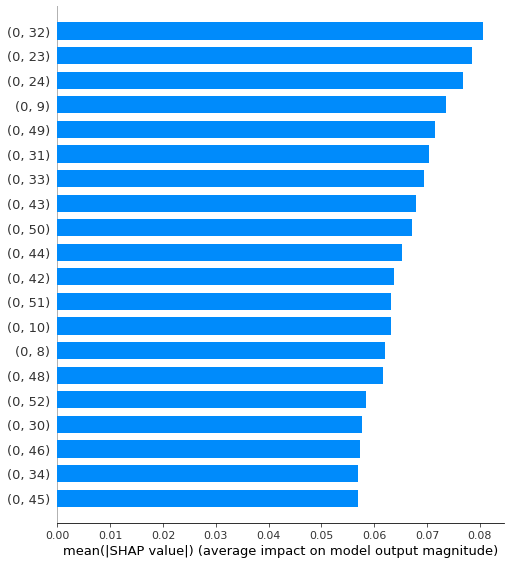

In [30]:
shap.summary_plot(tmp1, plot_type='bar', feature_names=list(product(range(6),range(60))))

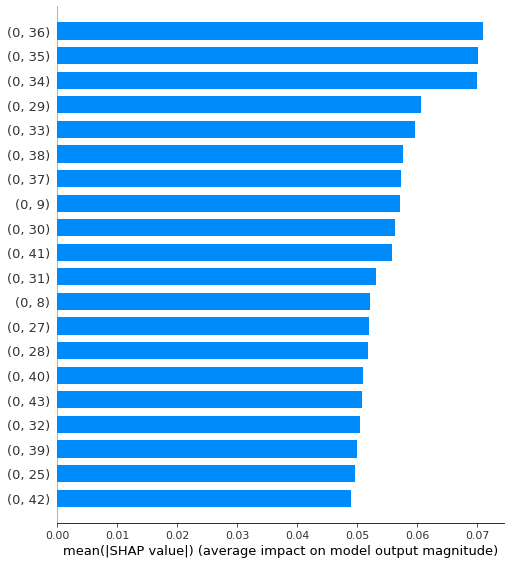

In [31]:
shap.summary_plot(tmp0, plot_type='bar', feature_names=list(product(range(6),range(60))))

#### It feels a little odd to have subject values dominant in the plot

### run with original data

In [32]:
class MyDataset(Dataset):
    def __init__(self, series, labels=None):
        self.X = series.drop(columns=['sequence','subject','step'])[['sensor_04']].values
        print(self.X.shape)
        self.X = self.X.reshape(-1,60,self.X.shape[1]).transpose([0,2,1]).copy()
        if labels is None:
            self.y = None
        else:
            self.y = labels['state'].values
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        ''' input tensor shape is N*C*L '''
        X = self.X[idx]
        if self.y is None:
            y = -1
        else:
            y = self.y[idx]
        return (torch.tensor(X, dtype=torch.float32), torch.tensor(y))

In [33]:
mydataset = MyDataset(train_series, train_labels)

(1558080, 1)


In [34]:
mydataset.X.shape

(25968, 1, 60)

In [35]:
model = MyModel(1)
train(mydataset)

23371 2597
0: 0.6921465195402051; test roc=0.5981029549918866 test loss=0.6877899765968323
1: 0.6727482153068565; test roc=0.6756886915098547 test loss=0.6403796672821045
2: 0.6266392489834574; test roc=0.7747121160360976 test loss=0.5694578886032104
3: 0.5574859033923039; test roc=0.8334824944724383 test loss=0.5072740316390991
4: 0.5200977468119777; test roc=0.8590839430257827 test loss=0.4715230166912079
5: 0.4967094520759248; test roc=0.869825917385487 test loss=0.45758727192878723
6: 0.483658646764215; test roc=0.8756867936345261 test loss=0.4463905394077301
7: 0.47843794165004033; test roc=0.8779144248014348 test loss=0.44840365648269653
8: 0.4698910320643196; test roc=0.8816585769730787 test loss=0.4378819167613983
9: 0.46821470471867077; test roc=0.8840617616078799 test loss=0.4439736604690552
10: 0.4598533544393096; test roc=0.8911292714056613 test loss=0.42487555742263794
11: 0.45620062578107523; test roc=0.889802241390763 test loss=0.4234609603881836
12: 0.4489131570091899; 

101: 0.38163847814582136; test roc=0.9241840322259232 test loss=0.35188618302345276
102: 0.3857506713544413; test roc=0.925059723764246 test loss=0.3494580090045929
103: 0.38302058987037335; test roc=0.9246329983583379 test loss=0.35156023502349854
104: 0.3860840162127709; test roc=0.9230897884817948 test loss=0.3556729853153229
105: 0.38161414132528937; test roc=0.924120572019624 test loss=0.3537220358848572
106: 0.388357649208171; test roc=0.9205834068760023 test loss=0.36378777027130127
107: 0.3793819552629129; test roc=0.9243853849365633 test loss=0.35169151425361633
108: 0.3854944153591735; test roc=0.9230337418509978 test loss=0.36037713289260864
109: 0.3853056149370817; test roc=0.9245212016397643 test loss=0.3512897789478302
110: 0.38560648032903905; test roc=0.9214727393932494 test loss=0.3585841655731201
111: 0.3805304562985313; test roc=0.9225044125601389 test loss=0.36080503463745117
112: 0.38372019731561313; test roc=0.9244610034066861 test loss=0.3543739318847656
113: 0.3

In [36]:
shap_loader = DataLoader(mydataset, shuffle=True, batch_size=1000)
X, y = next(iter(shap_loader))

In [37]:
shap_values = shap.DeepExplainer(model,X).shap_values(X)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


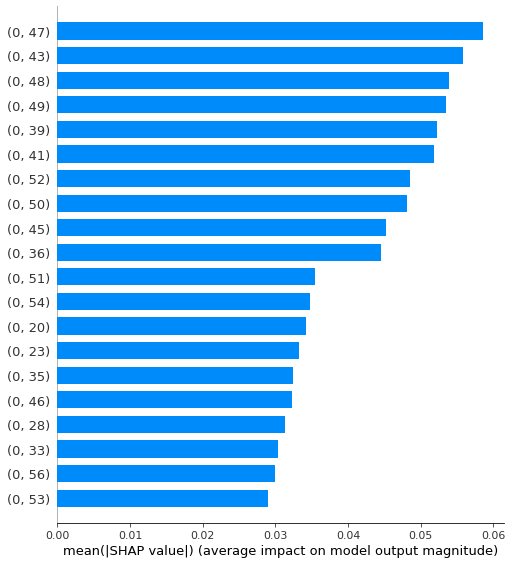

In [38]:
tmp = np.array(shap_values)
shap.summary_plot(tmp[0].reshape(1000,-1), plot_type='bar', feature_names=list(product(range(1),range(60))))

### the first 3 cols

In [39]:
train_series.columns

Index(['sequence', 'subject', 'step', 'sensor_04', 'sensor_04_square',
       'sensor_04_diff', 'sensor_04_subject_mean',
       'sensor_04_square_subject_mean', 'sensor_04_diff_subject_mean'],
      dtype='object')

In [40]:
class MyDataset(Dataset):
    def __init__(self, series, labels=None):
        self.X = series.drop(columns=['sequence','subject','step'])[['sensor_04','sensor_04_square','sensor_04_diff']].values
        print(self.X.shape)
        self.X = self.X.reshape(-1,60,self.X.shape[1]).transpose([0,2,1]).copy()
        if labels is None:
            self.y = None
        else:
            self.y = labels['state'].values
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        ''' input tensor shape is N*C*L '''
        X = self.X[idx]
        if self.y is None:
            y = -1
        else:
            y = self.y[idx]
        return (torch.tensor(X, dtype=torch.float32), torch.tensor(y))

In [41]:
mydataset = MyDataset(train_series, train_labels)
mydataset.X.shape

(1558080, 3)


(25968, 3, 60)

In [42]:
model = MyModel(3)
train(mydataset)

23371 2597
0: 0.6931419520785967; test roc=0.5466767609910705 test loss=0.6926249861717224
1: 0.6900570981106002; test roc=0.6654312684449759 test loss=0.6814107298851013
2: 0.6336246173197465; test roc=0.8167767434357237 test loss=0.5434612035751343
3: 0.5383011278141693; test roc=0.8422699537867357 test loss=0.49532607197761536
4: 0.5149526870068095; test roc=0.8543973771362959 test loss=0.48313334584236145
5: 0.4963641805056812; test roc=0.8652867333769845 test loss=0.46726617217063904
6: 0.4868543898307957; test roc=0.8686596136874769 test loss=0.46210023760795593
7: 0.4767094632470966; test roc=0.8753401348440422 test loss=0.4473380148410797
8: 0.4747705845146572; test roc=0.8763320712462399 test loss=0.4445226788520813
9: 0.46904521443309694; test roc=0.8780291869502094 test loss=0.4596042335033417
10: 0.46440800637418644; test roc=0.883009330429584 test loss=0.439517617225647
11: 0.45941326493966167; test roc=0.884065320124121 test loss=0.43486982583999634
12: 0.4555005345546634

101: 0.3692077744015272; test roc=0.9272410942200207 test loss=0.34767410159111023
102: 0.36884541019773737; test roc=0.9274629083990472 test loss=0.3454107642173767
103: 0.36499485829502765; test roc=0.9281289440221672 test loss=0.3428446352481842
104: 0.3718068357773043; test roc=0.9262906738406355 test loss=0.34816136956214905
105: 0.3662735479533772; test roc=0.9277677546236988 test loss=0.34346479177474976
106: 0.3652232549439029; test roc=0.9242501613194029 test loss=0.3567134141921997
107: 0.3662139866265981; test roc=0.9288456885017223 test loss=0.3406853973865509
108: 0.36812642188755906; test roc=0.927342215389871 test loss=0.3473269045352936
109: 0.3669922906746174; test roc=0.9278774755411316 test loss=0.3461979925632477
110: 0.3640251207602131; test roc=0.927008604492271 test loss=0.3469342291355133
111: 0.3645348251452521; test roc=0.9278872614607948 test loss=0.34396806359291077
112: 0.36613033014320906; test roc=0.9244959954830567 test loss=0.3527219891548157
113: 0.366

In [43]:
shap_loader = DataLoader(mydataset, shuffle=True, batch_size=1000)
X, y = next(iter(shap_loader))

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


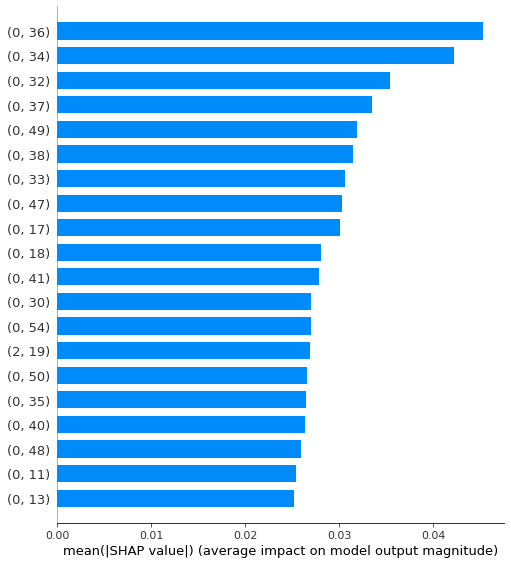

In [44]:
shap_values = shap.DeepExplainer(model,X).shap_values(X)
tmp = np.array(shap_values)
shap.summary_plot(tmp[0].reshape(1000,-1), plot_type='bar', feature_names=list(product(range(3),range(60))))

In [45]:
shap_values

[array([[[-4.57642716e-04,  5.11229737e-03,  6.44445233e-03, ...,
           4.52372804e-03, -3.44520854e-03,  0.00000000e+00],
         [-3.63271742e-04, -5.14561951e-04, -3.61926155e-04, ...,
          -6.48866466e-04,  1.62903627e-04,  0.00000000e+00],
         [ 0.00000000e+00,  2.61343084e-03,  4.71262680e-03, ...,
           6.87044172e-04,  8.92192475e-04,  0.00000000e+00]],
 
        [[-1.78893795e-03,  9.04334418e-04,  8.27296730e-03, ...,
          -4.22011781e-03, -7.41686323e-04,  0.00000000e+00],
         [-3.61900311e-04, -5.78404055e-04, -3.57591460e-04, ...,
          -5.95547201e-04,  1.57695526e-04,  0.00000000e+00],
         [ 0.00000000e+00,  3.48287215e-03,  9.29839723e-03, ...,
           2.25954689e-03, -9.03778244e-04,  0.00000000e+00]],
 
        [[-4.60534729e-03,  3.10383574e-03,  9.90897603e-03, ...,
          -5.60316630e-03, -1.91963289e-03,  0.00000000e+00],
         [-2.50886544e-04, -5.61838213e-04, -2.77391810e-04, ...,
          -6.23069296e-04,  1.63

### result 1 is about 0.935, 2 is about 0.923, 3 is about 0.93; about 0.01 better. The shap values do not seem indicative in this case

### add 02 in it to see

In [61]:
train_series = pd.read_csv('train.csv',index_col=['sequence','subject','step'])[['sensor_02','sensor_04']].reset_index()
train_labels = pd.read_csv('train_labels.csv', index_col=['sequence'])

In [62]:
train_series

,sequence,subject,step,sensor_02,sensor_04
0,0,47,0,1.000000,-1.004660
1,0,47,1,1.000000,0.162495
2,0,47,2,1.000000,0.473678
3,0,47,3,1.000000,-0.563287
4,0,47,4,1.000000,0.398579
...,...,...,...,...,...
1558075,25967,327,55,-1.666153,-0.930698
1558076,25967,327,56,-1.666153,0.775324
1558077,25967,327,57,-1.666153,0.308861
1558078,25967,327,58,-1.522820,-0.460541


In [63]:
scs = {}
for col in train_series.columns[3:]:
    sc = StandardScaler()
    train_series[col] = sc.fit_transform(train_series[col].values.reshape(-1,1))
    scs[col] = sc

In [64]:
scs

{'sensor_02': StandardScaler(), 'sensor_04': StandardScaler()}

In [65]:
def prep(df):
    for sensor in df.columns[3:]:
        df[sensor+'_square'] = np.square(df[sensor])
        df[sensor+'_diff'] = df[sensor].diff()
        df.loc[df['step']==0, sensor+'_diff'] = 0.0
        
        tmp = df.groupby(['subject','step']).agg({sensor:'mean'}).to_dict()[sensor]
        df[sensor+'_subject_mean'] = pd.Series(zip(df['subject'], df['step'])).map(tmp)
        
        tmp = df.groupby(['subject','step']).agg({sensor+'_square':'mean'}).to_dict()[sensor+'_square']
        df[sensor+'_square_subject_mean'] = pd.Series(zip(df['subject'], df['step'])).map(tmp)
        
        tmp = df.groupby(['subject','step']).agg({sensor+'_diff':'mean'}).to_dict()[sensor+'_diff']
        df[sensor+'_diff_subject_mean'] = pd.Series(zip(df['subject'], df['step'])).map(tmp)

In [66]:
train_series

,sequence,subject,step,sensor_02,sensor_04
0,0,47,0,0.529941,-0.595617
1,0,47,1,0.529941,0.097598
2,0,47,2,0.529941,0.282421
3,0,47,3,0.529941,-0.333470
4,0,47,4,0.529941,0.237816
...,...,...,...,...,...
1558075,25967,327,55,-0.630265,-0.551688
1558076,25967,327,56,-0.630265,0.461579
1558077,25967,327,57,-0.630265,0.184530
1558078,25967,327,58,-0.567891,-0.272446


In [67]:
prep(train_series)

In [68]:
train_series

,sequence,subject,step,sensor_02,sensor_04,sensor_02_square,sensor_02_diff,sensor_02_subject_mean,sensor_02_square_subject_mean,sensor_02_diff_subject_mean,sensor_04_square,sensor_04_diff,sensor_04_subject_mean,sensor_04_square_subject_mean,sensor_04_diff_subject_mean
0,0,47,0,0.529941,-0.595617,0.280837,0.000000,0.452602,0.214344,0.000000,0.354760,0.000000,-0.126449,1.176818,0.000000
1,0,47,1,0.529941,0.097598,0.280837,0.000000,0.452635,0.214053,0.000033,0.009525,0.693215,0.004183,1.899121,0.130632
2,0,47,2,0.529941,0.282421,0.280837,0.000000,0.448361,0.210081,-0.004275,0.079761,0.184823,0.065081,1.999208,0.060898
3,0,47,3,0.529941,-0.333470,0.280837,0.000000,0.447412,0.209243,-0.000948,0.111202,-0.615891,-0.048740,1.405967,-0.113821
4,0,47,4,0.529941,0.237816,0.280837,0.000000,0.445928,0.207633,-0.001484,0.056557,0.571286,0.070759,0.765872,0.119499
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1558075,25967,327,55,-0.630265,-0.551688,0.397233,0.000000,-0.121551,0.078799,-0.002821,0.304360,-0.365804,-0.087041,0.118400,-0.077667
1558076,25967,327,56,-0.630265,0.461579,0.397233,0.000000,-0.136205,0.078345,-0.014654,0.213055,1.013267,-0.073663,0.082456,0.013378
1558077,25967,327,57,-0.630265,0.184530,0.397233,0.000000,-0.131746,0.074798,0.004459,0.034051,-0.277049,-0.017011,0.046591,0.056652
1558078,25967,327,58,-0.567891,-0.272446,0.322501,0.062373,-0.123615,0.073205,0.008131,0.074227,-0.456975,0.039722,0.082246,0.056733


<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>


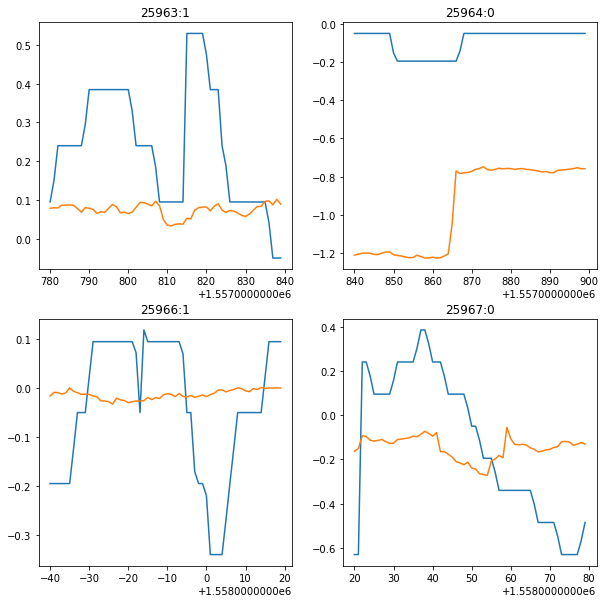

In [73]:
seqs = [25963,25964,25966,25967]
fig, axes = plt.subplots(2,2,figsize=(10,10))
axes = axes.reshape(-1)
for i, seq in enumerate(seqs):
    ax = axes[i]
    print(type(ax))
    ax.plot(train_series.loc[train_series['sequence']==seq, 'sensor_02']);
    ax.plot(train_series.loc[train_series['sequence']==seq, 'sensor_02_subject_mean']);
    ax.set_title(str(seq) + ':' + str(train_labels.loc[seq].values[0]));

In [69]:
class MyDataset(Dataset):
    def __init__(self, series, labels=None):
        self.X = series.drop(columns=['sequence','subject','step']).values
        self.X = self.X.reshape(-1,60,series.shape[1]-3).transpose([0,2,1]).copy()
        if labels is None:
            self.y = None
        else:
            self.y = labels['state'].values
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        ''' input tensor shape is N*C*L '''
        X = self.X[idx]
        if self.y is None:
            y = -1
        else:
            y = self.y[idx]
        return (torch.tensor(X, dtype=torch.float32), torch.tensor(y))

In [70]:
mydataset = MyDataset(train_series, train_labels)

In [71]:
mydataset.X.shape

(25968, 12, 60)

In [74]:
model = MyModel(12)
train(mydataset)

23371 2597
0: 0.6897441924758331; test roc=0.5792469705165068 test loss=0.6842717528343201
1: 0.672822306160341; test roc=0.6846905514276767 test loss=0.6449769735336304
2: 0.6254543070883231; test roc=0.787853123428322 test loss=0.5827734470367432
3: 0.5751273719017101; test roc=0.8290927681460605 test loss=0.5200384855270386
4: 0.5333885398318519; test roc=0.855850141391712 test loss=0.4810243844985962
5: 0.5047186113376579; test roc=0.8660681242349192 test loss=0.46132487058639526
6: 0.4846968554464977; test roc=0.8736323435913494 test loss=0.4509708285331726
7: 0.4706087206675598; test roc=0.8763267334718783 test loss=0.44720348715782166
8: 0.46623785593131095; test roc=0.8825155863011359 test loss=0.4345654845237732
9: 0.4555098222442149; test roc=0.887300011387252 test loss=0.42732125520706177
10: 0.45389612191275625; test roc=0.8900673508507226 test loss=0.4237378239631653
11: 0.447689635416677; test roc=0.8898286337195511 test loss=0.4220374822616577
12: 0.43851869518036846; te

101: 0.32525360716878154; test roc=0.9359609417257381 test loss=0.3239890933036804
102: 0.33026094948580825; test roc=0.9349372752203907 test loss=0.3253711760044098
103: 0.32581627272905656; test roc=0.9330340621174595 test loss=0.3300049602985382
104: 0.3280131383875328; test roc=0.9347356259667303 test loss=0.32813936471939087
105: 0.3233489771247048; test roc=0.9353645937123389 test loss=0.32395175099372864
106: 0.3284831714208806; test roc=0.9339569039959764 test loss=0.3304695188999176
107: 0.32585237758463437; test roc=0.9339746965771818 test loss=0.3297363519668579
108: 0.3302278146782132; test roc=0.9344334486292595 test loss=0.3291226029396057
109: 0.32578834915037697; test roc=0.9363031523709208 test loss=0.32166433334350586
110: 0.3203736895631649; test roc=0.9371296177679089 test loss=0.3191726803779602
111: 0.32528626208706585; test roc=0.9371139009878442 test loss=0.3191516101360321
112: 0.3224261039139947; test roc=0.9343619817614182 test loss=0.3324021100997925
113: 0.

In [77]:
class MyModel(nn.Module):
    def __init__(self, input_channel):
        super(MyModel, self).__init__()
        torch.manual_seed(123)
        self.conv1d_1 = nn.Conv1d(input_channel, 24, 5, padding='valid')
#         self.maxpool_1 = nn.MaxPool1d(5)
        self.maxpool_1 = nn.Conv1d(24, 24, 5, groups=24, stride=5, padding='valid')
        self.conv1d_2 = nn.Conv1d(24, 48, 5, padding='valid')
#         self.maxpool_2 = nn.MaxPool1d(7)
        self.maxpool_2 = nn.Conv1d(48, 48, 7, groups=48, stride=7, padding='valid')
        self.fc1 = nn.Linear(48, 12)
        self.fc2 = nn.Linear(12, 6)
        self.fc3 = nn.Linear(6,2)
        self.dropout = nn.Dropout(p=0.2)
    
    def forward(self, X):
        ''' input shape (N,C,L) '''
        X = F.relu(self.conv1d_1(X))
        X = self.dropout(X)
        X = self.maxpool_1(X)
        X = F.relu(self.conv1d_2(X))
        X = self.dropout(X)
        X = self.maxpool_2(X)
        
        X = torch.squeeze(X, dim=2)
        X = self.dropout(X)
        X = F.relu(self.fc1(X))
        X = self.dropout(X)
        X = F.relu(self.fc2(X))
        output = F.log_softmax(self.fc3(X), dim=1)
        
        return output

In [78]:
model = MyModel(12)
train(mydataset)

23371 2597
0: 0.6842059779726216; test roc=0.6098508032757328 test loss=0.6755220890045166
1: 0.650438965983846; test roc=0.6838581551702869 test loss=0.6318672299385071
2: 0.6142053960131811; test roc=0.7637951812945407 test loss=0.5928449034690857
3: 0.567367817230236; test roc=0.8089930822444275 test loss=0.5348806381225586
4: 0.5308198703610032; test roc=0.8466439633330487 test loss=0.4958206117153168
5: 0.5001855972902617; test roc=0.8667970269782979 test loss=0.4633065164089203
6: 0.47155855554558285; test roc=0.8833008322183316 test loss=0.4357396364212036
7: 0.44442670486073943; test roc=0.8961885918713999 test loss=0.4151793122291565
8: 0.41908487407235173; test roc=0.9029978126986838 test loss=0.39459240436553955
9: 0.40683212633461113; test roc=0.9018377364040957 test loss=0.4116520285606384
10: 0.3977980130031252; test roc=0.9120275476603942 test loss=0.37670162320137024
11: 0.3900326638030259; test roc=0.91384594945958 test loss=0.3734239339828491
12: 0.38071233070094096; 

101: 0.2682442281091225; test roc=0.9475996621781915 test loss=0.2919729948043823
102: 0.2674548159579421; test roc=0.9476038137804728 test loss=0.2914137840270996
103: 0.26516581033845243; test roc=0.9450416820869038 test loss=0.3007279336452484
104: 0.2639647655781679; test roc=0.9459502899004565 test loss=0.3022853434085846
105: 0.26714721548277254; test roc=0.9440746552983935 test loss=0.30363592505455017
106: 0.2660825870487066; test roc=0.9459238975716684 test loss=0.3012447655200958
107: 0.26737534195142626; test roc=0.9440221671838378 test loss=0.300714373588562
108: 0.26141066813972885; test roc=0.9486778925992352 test loss=0.2896791994571686
109: 0.26453338849529734; test roc=0.9463882839411278 test loss=0.30026867985725403
110: 0.2651353865705045; test roc=0.944556241163018 test loss=0.2998589873313904
111: 0.26418509254977474; test roc=0.9467699348079825 test loss=0.29761043190956116
112: 0.26452913028525377; test roc=0.9463328303963713 test loss=0.2980118989944458
113: 0.2

does the roc keep increasing when we make the models more complicated?

In [83]:
class MyModel(nn.Module):
    def __init__(self, input_channel):
        super(MyModel, self).__init__()
        torch.manual_seed(123)
        self.conv1d_1 = nn.Conv1d(input_channel, 48, 5, padding='valid')
#         self.maxpool_1 = nn.MaxPool1d(5)
        self.maxpool_1 = nn.Conv1d(48, 48, 5, groups=48, stride=5, padding='valid')
        self.conv1d_2 = nn.Conv1d(48, 96, 5, padding='valid')
#         self.maxpool_2 = nn.MaxPool1d(7)
        self.maxpool_2 = nn.Conv1d(96, 96, 7, groups=96, stride=7, padding='valid')
        self.fc1 = nn.Linear(96, 24)
        self.fc2 = nn.Linear(24, 6)
        self.fc3 = nn.Linear(6,2)
        self.dropout = nn.Dropout(p=0.3)
    
    def forward(self, X):
        ''' input shape (N,C,L) '''
        X = F.relu(self.conv1d_1(X))
        X = self.dropout(X)
        X = self.maxpool_1(X)
        X = F.relu(self.conv1d_2(X))
        X = self.dropout(X)
        X = self.maxpool_2(X)
        
        X = torch.squeeze(X, dim=2)
        X = self.dropout(X)
        X = F.relu(self.fc1(X))
        X = self.dropout(X)
        X = F.relu(self.fc2(X))
        output = F.log_softmax(self.fc3(X), dim=1)
        
        return output

p=0.2 dropout results in overfitting; p=0.5 probably too much???

In [84]:
model = MyModel(12)
train(mydataset)

23371 2597
0: 0.6843913411110695; test roc=0.6174248085518262 test loss=0.6748600602149963
1: 0.641981385295981; test roc=0.763779167971456 test loss=0.5870140790939331
2: 0.5700311839980944; test roc=0.8367797563128077 test loss=0.529532790184021
3: 0.5127453474738133; test roc=0.8554839107619019 test loss=0.47660303115844727
4: 0.48734976780296757; test roc=0.874020221861626 test loss=0.4493938982486725
5: 0.4643665799626969; test roc=0.8864741390763041 test loss=0.429103285074234
6: 0.447195722313259; test roc=0.8951604772207513 test loss=0.4120512306690216
7: 0.43149357543506917; test roc=0.8955278940226417 test loss=0.413646936416626
8: 0.4197910939383163; test roc=0.9089381624771069 test loss=0.38499513268470764
9: 0.4100568102954273; test roc=0.9079014480788757 test loss=0.3978038728237152
10: 0.398801433918162; test roc=0.9157076465396988 test loss=0.37160831689834595
11: 0.3899099910107755; test roc=0.9156857023562124 test loss=0.3718985915184021
12: 0.383194314728198; test ro

101: 0.2528296987927443; test roc=0.950069865535533 test loss=0.29288238286972046
102: 0.25210648516652817; test roc=0.949376844497585 test loss=0.2945359945297241
103: 0.24863267746848394; test roc=0.9503681878137427 test loss=0.28988558053970337
104: 0.24277325181658638; test roc=0.9488169712756569 test loss=0.2978383004665375
105: 0.2481493321976844; test roc=0.948220623262258 test loss=0.2966349422931671
106: 0.24839981490761523; test roc=0.9480192705516175 test loss=0.2969669699668884
107: 0.24623691030511358; test roc=0.9474700728784127 test loss=0.29836106300354004
108: 0.24846772622385777; test roc=0.948567282052742 test loss=0.29506900906562805
109: 0.24218425168585478; test roc=0.9508497736783671 test loss=0.2943693995475769
110: 0.24832062485776987; test roc=0.9491102523225249 test loss=0.29213231801986694
111: 0.24362006635309047; test roc=0.9483255994913694 test loss=0.3100576102733612
112: 0.2454568433887075; test roc=0.9501825518831668 test loss=0.2902331054210663
113: 0

### now increasing the model complexity only improves the fit a little

In [86]:
shap_loader = DataLoader(mydataset, shuffle=True, batch_size=1000)
X, y = next(iter(shap_loader))

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


IndexError: list index out of range

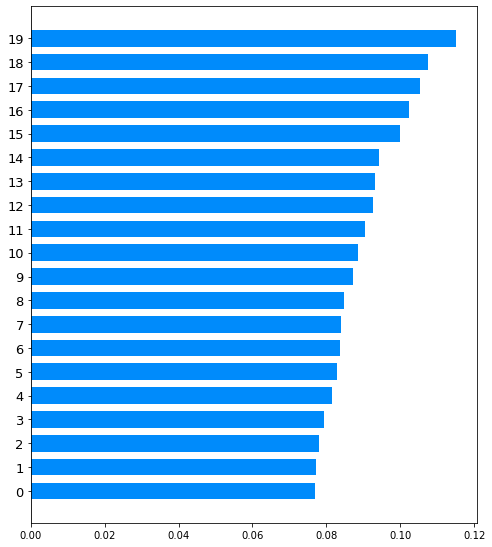

In [87]:
shap_values = shap.DeepExplainer(model,X).shap_values(X)
tmp = np.array(shap_values)

In [89]:
train_series.columns

Index(['sequence', 'subject', 'step', 'sensor_02', 'sensor_04',
       'sensor_02_square', 'sensor_02_diff', 'sensor_02_subject_mean',
       'sensor_02_square_subject_mean', 'sensor_02_diff_subject_mean',
       'sensor_04_square', 'sensor_04_diff', 'sensor_04_subject_mean',
       'sensor_04_square_subject_mean', 'sensor_04_diff_subject_mean'],
      dtype='object')

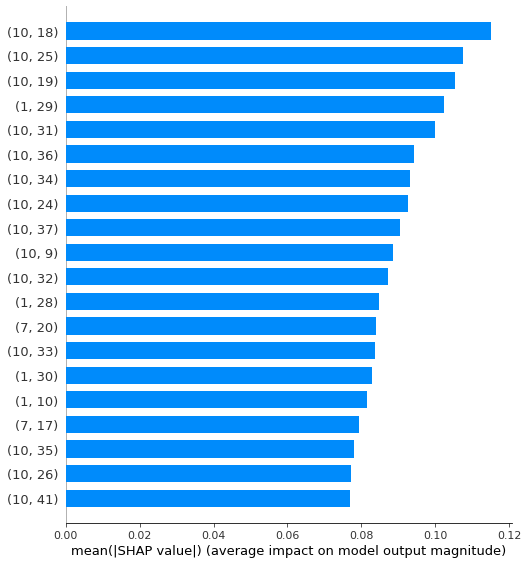

In [88]:
shap.summary_plot(tmp[0].reshape(1000,-1), plot_type='bar', feature_names=list(product(range(12),range(60))))

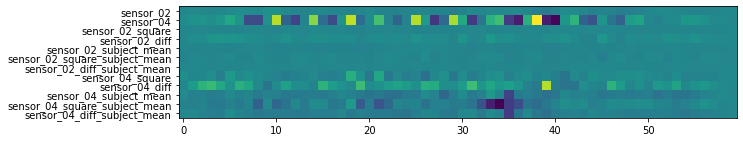

In [99]:
plt.figure(figsize=(10,30))
plt.imshow(shap_values[0][0]);
plt.yticks(range(12),train_series.columns[3:]);

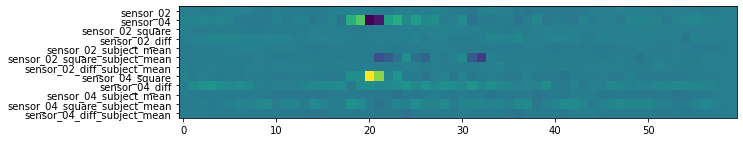

In [100]:
plt.figure(figsize=(10,30))
plt.imshow(shap_values[0][1]);
plt.yticks(range(12),train_series.columns[3:]);

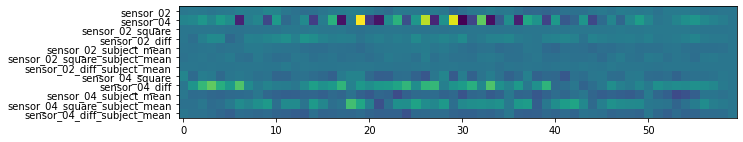

In [106]:
plt.figure(figsize=(10,30))
plt.imshow(shap_values[0][2]);
plt.yticks(range(12),train_series.columns[3:]);

In [103]:
np.sum(np.abs(shap_values[0][2]), axis=1)

array([0.16464001, 1.25409406, 0.04949108, 0.31765171, 0.13471876,
       0.11030392, 0.02463795, 0.31431452, 0.92553581, 0.48252309,
       0.61408611, 0.41790157])

#### don't think the shap values tell too much

In [115]:
train_series = pd.read_csv('train.csv',index_col=['sequence','subject','step'])[['sensor_04','sensor_10']].reset_index()
train_labels = pd.read_csv('train_labels.csv', index_col=['sequence'])

In [116]:
scs = {}
for col in train_series.columns[3:]:
    sc = StandardScaler()
    train_series[col] = sc.fit_transform(train_series[col].values.reshape(-1,1))
    scs[col] = sc

In [117]:
prep(train_series)

In [118]:
train_series

,sequence,subject,step,sensor_04,sensor_10,sensor_04_square,sensor_04_diff,sensor_04_subject_mean,sensor_04_square_subject_mean,sensor_04_diff_subject_mean,sensor_10_square,sensor_10_diff,sensor_10_subject_mean,sensor_10_square_subject_mean,sensor_10_diff_subject_mean
0,0,47,0,-0.595617,-0.513943,0.354760,0.000000,-0.126449,1.176818,0.000000,0.264138,0.000000,0.028629,0.417686,0.000000
1,0,47,1,0.097598,0.042977,0.009525,0.693215,0.004183,1.899121,0.130632,0.001847,0.556920,0.115828,0.581061,0.087199
2,0,47,2,0.282421,0.234122,0.079761,0.184823,0.065081,1.999208,0.060898,0.054813,0.191145,-0.000242,0.561554,-0.116070
3,0,47,3,-0.333470,-0.226680,0.111202,-0.615891,-0.048740,1.405967,-0.113821,0.051384,-0.460802,-0.079026,0.748663,-0.078785
4,0,47,4,0.237816,0.423661,0.056557,0.571286,0.070759,0.765872,0.119499,0.179489,0.650341,0.058413,0.474181,0.137439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1558075,25967,327,55,-0.551688,-0.377539,0.304360,-0.365804,-0.087041,0.118400,-0.077667,0.142536,-0.065998,-0.022131,0.073458,-0.045577
1558076,25967,327,56,0.461579,0.360436,0.213055,1.013267,-0.073663,0.082456,0.013378,0.129914,0.737975,-0.084750,0.087653,-0.062618
1558077,25967,327,57,0.184530,0.373708,0.034051,-0.277049,-0.017011,0.046591,0.056652,0.139658,0.013272,-0.022201,0.068838,0.062549
1558078,25967,327,58,-0.272446,-0.477354,0.074227,-0.456975,0.039722,0.082246,0.056733,0.227866,-0.851062,0.048534,0.064976,0.070735


In [119]:
class MyModel(nn.Module):
    def __init__(self, input_channel):
        super(MyModel, self).__init__()
        torch.manual_seed(123)
        self.conv1d_1 = nn.Conv1d(input_channel, 24, 5, padding='valid')
#         self.maxpool_1 = nn.MaxPool1d(5)
        self.maxpool_1 = nn.Conv1d(24, 24, 5, groups=24, stride=5, padding='valid')
        self.conv1d_2 = nn.Conv1d(24, 48, 5, padding='valid')
#         self.maxpool_2 = nn.MaxPool1d(7)
        self.maxpool_2 = nn.Conv1d(48, 48, 7, groups=48, stride=7, padding='valid')
        self.fc1 = nn.Linear(48, 12)
        self.fc2 = nn.Linear(12, 6)
        self.fc3 = nn.Linear(6,2)
        self.dropout = nn.Dropout(p=0.2)
    
    def forward(self, X):
        ''' input shape (N,C,L) '''
        X = F.relu(self.conv1d_1(X))
        X = self.dropout(X)
        X = self.maxpool_1(X)
        X = F.relu(self.conv1d_2(X))
        X = self.dropout(X)
        X = self.maxpool_2(X)
        
        X = torch.squeeze(X, dim=2)
        X = self.dropout(X)
        X = F.relu(self.fc1(X))
        X = self.dropout(X)
        X = F.relu(self.fc2(X))
        output = F.log_softmax(self.fc3(X), dim=1)
        
        return output

In [120]:
mydataset = MyDataset(train_series, train_labels)

In [121]:
mydataset.X.shape

(25968, 12, 60)

In [122]:
model = MyModel(12)
train(mydataset)

23371 2597
0: 0.6858259215240051; test roc=0.6772562179140452 test loss=0.6641967296600342
1: 0.6018687275452606; test roc=0.8041635826192578 test loss=0.5376763939857483
2: 0.5280118853212101; test roc=0.8595732390089295 test loss=0.4807974398136139
3: 0.4918956907420546; test roc=0.8690688430551998 test loss=0.4597415626049042
4: 0.46352813815632915; test roc=0.884571222516393 test loss=0.43080174922943115
5: 0.4440758235978609; test roc=0.8908697962630835 test loss=0.42019185423851013
6: 0.4354050616735284; test roc=0.8937447808428463 test loss=0.418753057718277
7: 0.4186613214058807; test roc=0.8996219669579906 test loss=0.4037002623081207
8: 0.41124459926299917; test roc=0.9054247207750924 test loss=0.3917996883392334
9: 0.40604931229085417; test roc=0.9055172421973601 test loss=0.4003443121910095
10: 0.39610756527224256; test roc=0.9097429802336284 test loss=0.38141122460365295
11: 0.3912847438806196; test roc=0.9103058188857573 test loss=0.3812338709831238
12: 0.3854583676146184

101: 0.2798266705407864; test roc=0.938229495829419 test loss=0.31658607721328735
102: 0.27886441533482176; test roc=0.9392430798720832 test loss=0.3164577782154083
103: 0.27630734386536315; test roc=0.9380681764264905 test loss=0.322480171918869
104: 0.27924846012434906; test roc=0.9381019823307807 test loss=0.3208063244819641
105: 0.2779532276330825; test roc=0.9383472234083943 test loss=0.3184901773929596
106: 0.2766634929829724; test roc=0.9374406913959822 test loss=0.3290638327598572
107: 0.2751400404653614; test roc=0.9400019334604911 test loss=0.3131180703639984
108: 0.275716595751785; test roc=0.9353370152114707 test loss=0.3295525014400482
109: 0.27045425634054443; test roc=0.9394826866323152 test loss=0.3168964982032776
110: 0.2790903685668901; test roc=0.9392715480020118 test loss=0.31656521558761597
111: 0.277388196781416; test roc=0.9388718080109317 test loss=0.32522135972976685
112: 0.27317466883340363; test roc=0.9363120486615234 test loss=0.3354235291481018
113: 0.27345

In [123]:
train_series = pd.read_csv('train.csv',index_col=['sequence','subject','step'])[['sensor_02','sensor_04','sensor_10']].reset_index()
train_labels = pd.read_csv('train_labels.csv', index_col=['sequence'])

In [124]:
scs = {}
for col in train_series.columns[3:]:
    sc = StandardScaler()
    train_series[col] = sc.fit_transform(train_series[col].values.reshape(-1,1))
    scs[col] = sc

In [125]:
prep(train_series)

In [126]:
train_series

,sequence,subject,step,sensor_02,sensor_04,sensor_10,sensor_02_square,sensor_02_diff,sensor_02_subject_mean,sensor_02_square_subject_mean,...,sensor_04_square,sensor_04_diff,sensor_04_subject_mean,sensor_04_square_subject_mean,sensor_04_diff_subject_mean,sensor_10_square,sensor_10_diff,sensor_10_subject_mean,sensor_10_square_subject_mean,sensor_10_diff_subject_mean
0,0,47,0,0.529941,-0.595617,-0.513943,0.280837,0.000000,0.452602,0.214344,...,0.354760,0.000000,-0.126449,1.176818,0.000000,0.264138,0.000000,0.028629,0.417686,0.000000
1,0,47,1,0.529941,0.097598,0.042977,0.280837,0.000000,0.452635,0.214053,...,0.009525,0.693215,0.004183,1.899121,0.130632,0.001847,0.556920,0.115828,0.581061,0.087199
2,0,47,2,0.529941,0.282421,0.234122,0.280837,0.000000,0.448361,0.210081,...,0.079761,0.184823,0.065081,1.999208,0.060898,0.054813,0.191145,-0.000242,0.561554,-0.116070
3,0,47,3,0.529941,-0.333470,-0.226680,0.280837,0.000000,0.447412,0.209243,...,0.111202,-0.615891,-0.048740,1.405967,-0.113821,0.051384,-0.460802,-0.079026,0.748663,-0.078785
4,0,47,4,0.529941,0.237816,0.423661,0.280837,0.000000,0.445928,0.207633,...,0.056557,0.571286,0.070759,0.765872,0.119499,0.179489,0.650341,0.058413,0.474181,0.137439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1558075,25967,327,55,-0.630265,-0.551688,-0.377539,0.397233,0.000000,-0.121551,0.078799,...,0.304360,-0.365804,-0.087041,0.118400,-0.077667,0.142536,-0.065998,-0.022131,0.073458,-0.045577
1558076,25967,327,56,-0.630265,0.461579,0.360436,0.397233,0.000000,-0.136205,0.078345,...,0.213055,1.013267,-0.073663,0.082456,0.013378,0.129914,0.737975,-0.084750,0.087653,-0.062618
1558077,25967,327,57,-0.630265,0.184530,0.373708,0.397233,0.000000,-0.131746,0.074798,...,0.034051,-0.277049,-0.017011,0.046591,0.056652,0.139658,0.013272,-0.022201,0.068838,0.062549
1558078,25967,327,58,-0.567891,-0.272446,-0.477354,0.322501,0.062373,-0.123615,0.073205,...,0.074227,-0.456975,0.039722,0.082246,0.056733,0.227866,-0.851062,0.048534,0.064976,0.070735


In [127]:
mydataset = MyDataset(train_series, train_labels)

In [128]:
mydataset.X.shape

(25968, 18, 60)

In [135]:
model = MyModel(18)
train(mydataset)

23371 2597
0: 0.6918277956112109; test roc=0.5691410809348935 test loss=0.690560519695282
1: 0.6812021171070891; test roc=0.6267232114897372 test loss=0.6658067107200623
2: 0.6474755454862191; test roc=0.6980693863220125 test loss=0.6223955750465393
3: 0.6056712671465941; test roc=0.7728249162562512 test loss=0.5665498971939087
4: 0.5550394749823515; test roc=0.8368435130621269 test loss=0.5130583047866821
5: 0.5122169400841683; test roc=0.8586542521896737 test loss=0.4712488055229187
6: 0.4838250866431969; test roc=0.8737853597897154 test loss=0.4460746645927429
7: 0.46466557277518505; test roc=0.8819586785094088 test loss=0.4368041455745697
8: 0.4443748531458462; test roc=0.8939876495762993 test loss=0.41138702630996704
9: 0.42776233714916634; test roc=0.8932234582135299 test loss=0.4241211414337158
10: 0.417745290500944; test roc=0.9066411402434974 test loss=0.38923391699790955
11: 0.40795732609145646; test roc=0.9074708676137064 test loss=0.38333362340927124
12: 0.3985893009019691;

101: 0.26688884985199035; test roc=0.9358865094276958 test loss=0.32842275500297546
102: 0.2703023100688886; test roc=0.9379703172298611 test loss=0.3203468322753906
103: 0.27223238331618377; test roc=0.9383279481120884 test loss=0.3210242986679077
104: 0.2683817412209936; test roc=0.9348020516032302 test loss=0.3288195729255676
105: 0.2665093407761091; test roc=0.936527338894108 test loss=0.32713133096694946
106: 0.26930111076772545; test roc=0.934891311052277 test loss=0.3302059769630432
107: 0.26477084931821887; test roc=0.9351071943709018 test loss=0.32791805267333984
108: 0.26793998226974175; test roc=0.9382194133667359 test loss=0.32222622632980347
109: 0.2703825107344736; test roc=0.9366044400793312 test loss=0.3249710500240326
110: 0.26815569953324525; test roc=0.9354176749129348 test loss=0.3280915915966034
111: 0.27028558968128136; test roc=0.9377058008559418 test loss=0.3232276141643524
112: 0.26723964767831265; test roc=0.9349598124899176 test loss=0.33250418305397034
113: 

In [136]:
class MyModel(nn.Module):
    def __init__(self, input_channel):
        super(MyModel, self).__init__()
        torch.manual_seed(123)
        self.conv1d_1 = nn.Conv1d(input_channel, 48, 5, padding='valid')
#         self.maxpool_1 = nn.MaxPool1d(5)
        self.maxpool_1 = nn.Conv1d(48, 48, 5, groups=48, stride=5, padding='valid')
        self.conv1d_2 = nn.Conv1d(48, 96, 5, padding='valid')
#         self.maxpool_2 = nn.MaxPool1d(7)
        self.maxpool_2 = nn.Conv1d(96, 96, 7, groups=96, stride=7, padding='valid')
        self.fc1 = nn.Linear(96, 24)
        self.fc2 = nn.Linear(24, 6)
        self.fc3 = nn.Linear(6,2)
        self.dropout = nn.Dropout(p=0.3)
    
    def forward(self, X):
        ''' input shape (N,C,L) '''
        X = F.relu(self.conv1d_1(X))
        X = self.dropout(X)
        X = self.maxpool_1(X)
        X = F.relu(self.conv1d_2(X))
        X = self.dropout(X)
        X = self.maxpool_2(X)
        
        X = torch.squeeze(X, dim=2)
        X = self.dropout(X)
        X = F.relu(self.fc1(X))
        X = self.dropout(X)
        X = F.relu(self.fc2(X))
        output = F.log_softmax(self.fc3(X), dim=1)
        
        return output

In [137]:
model = MyModel(18)
train(mydataset)

23371 2597
0: 0.6869503113191193; test roc=0.6002392509086079 test loss=0.683505654335022
1: 0.6577012193488103; test roc=0.7341533340924834 test loss=0.6121887564659119
2: 0.5836312561624087; test roc=0.8320015586301136 test loss=0.5181608200073242
3: 0.5137166031736917; test roc=0.8652633064783974 test loss=0.4582805335521698
4: 0.47128545363233176; test roc=0.8885650639109518 test loss=0.42227914929389954
5: 0.446614242739796; test roc=0.8951821248612178 test loss=0.40950316190719604
6: 0.43209450089637175; test roc=0.9056085774475475 test loss=0.39225050806999207
7: 0.41711128009237347; test roc=0.907712253632059 test loss=0.38499608635902405
8: 0.4038925965567526; test roc=0.9162722644499482 test loss=0.3705613613128662
9: 0.392612807255344; test roc=0.9184892200681337 test loss=0.3734174966812134
10: 0.3835764722959572; test roc=0.9202281483379356 test loss=0.3625682294368744
11: 0.37507998861207015; test roc=0.9226176919938127 test loss=0.35885605216026306
12: 0.3645722454830677

101: 0.2349677158475871; test roc=0.9470866427534375 test loss=0.298257976770401
102: 0.23558716350039186; test roc=0.9470305961226407 test loss=0.30442649126052856
103: 0.23402933613091337; test roc=0.9477924151412493 test loss=0.30849453806877136
104: 0.23932133836070063; test roc=0.9468132300889156 test loss=0.30690982937812805
105: 0.2345683524421517; test roc=0.9457367789259924 test loss=0.3018287122249603
106: 0.23667507446994066; test roc=0.9458906847534185 test loss=0.3099319338798523
107: 0.23131292175760926; test roc=0.9453364458488722 test loss=0.3077656030654907
108: 0.2324265288256399; test roc=0.9450879427980375 test loss=0.3114432394504547
109: 0.23561792385631203; test roc=0.9463446921171748 test loss=0.3039834499359131
110: 0.234149365332455; test roc=0.9473903028060088 test loss=0.2997971773147583
111: 0.23150004135935467; test roc=0.9470184378588171 test loss=0.30216988921165466
112: 0.23231436970448557; test roc=0.9461646905039808 test loss=0.3099750578403473
113: 0

In [182]:
class MyModel(nn.Module):
    def __init__(self, input_channel):
        super(MyModel, self).__init__()
        torch.manual_seed(123)
        self.conv1d_1 = nn.Conv1d(input_channel, 36, 3, padding='valid')
        self.maxpool_1 = nn.Conv1d(36, 36, 3, groups=36, stride=3, padding='valid')
        self.conv1d_2 = nn.Conv1d(36, 72, 3, padding='valid')
        self.maxpool_2 = nn.Conv1d(72, 72, 3, groups=72, stride=3, padding='valid')
        self.conv1d_3 = nn.Conv1d(72, 144, 3, padding='valid')
        self.maxpool_3 = nn.Conv1d(144, 144, 3, groups=144, stride=3, padding='valid')

        self.fc1 = nn.Linear(144, 72)
        self.fc2 = nn.Linear(72, 36)
        self.fc3 = nn.Linear(36, 2)
        self.dropout = nn.Dropout(p=0.3)
    
    def forward(self, X):
        ''' input shape (N,C,L) '''
        X = F.relu(self.conv1d_1(X))
        X = self.dropout(X)
        X = self.maxpool_1(X)

        X = F.relu(self.conv1d_2(X))
        X = self.dropout(X)
        X = self.maxpool_2(X)

        X = F.relu(self.conv1d_3(X))
        X = self.dropout(X)
        X = self.maxpool_3(X)
        
        X = torch.squeeze(X, dim=2)
        X = F.relu(self.fc1(X))
        X = self.dropout(X)
        X = F.relu(self.fc2(X))
        X = self.dropout(X)
        output = F.log_softmax(self.fc3(X), dim=1)
        
        return output

In [183]:
model = MyModel(18)

In [175]:
train_loader = DataLoader(mydataset, batch_size=1)

In [176]:
X, y = next(iter(train_loader))

In [177]:
model(X)

tensor([[-0.6367, -0.7530]], grad_fn=<LogSoftmaxBackward0>)

In [184]:
model = MyModel(18)
train(mydataset)

23371 2597
0: 0.6899207103574267; test roc=0.6157893737960354 test loss=0.6783171892166138
1: 0.656552415858704; test roc=0.726602162628937 test loss=0.6177250742912292
2: 0.5920325128085745; test roc=0.824203663373853 test loss=0.5263066291809082
3: 0.5269808600123941; test roc=0.8520665489983963 test loss=0.4782484471797943
4: 0.49369628948999267; test roc=0.8710156479820841 test loss=0.44857949018478394
5: 0.47529988070746443; test roc=0.8845534299351876 test loss=0.42974790930747986
6: 0.4485769262911547; test roc=0.8868314734155114 test loss=0.4412483274936676
7: 0.43281747971086637; test roc=0.8923210778033992 test loss=0.42700448632240295
8: 0.42314855457831446; test roc=0.9026644983441037 test loss=0.3946932256221771
9: 0.4102786102727362; test roc=0.9069317524031846 test loss=0.3880038857460022
10: 0.4043774443014785; test roc=0.9083563450716924 test loss=0.3936067819595337
11: 0.39704283870060697; test roc=0.9081641851946746 test loss=0.3913063704967499
12: 0.3918619906992596

101: 0.24189582538680737; test roc=0.9439670101821013 test loss=0.3189180791378021
102: 0.24053410772518088; test roc=0.9419368766665719 test loss=0.34320780634880066
103: 0.24516470769899176; test roc=0.9457249172051888 test loss=0.31352153420448303
104: 0.24147924531419676; test roc=0.9467708244370427 test loss=0.3171466886997223
105: 0.2407941218709605; test roc=0.9425225491312476 test loss=0.3356025815010071
106: 0.24090343678437784; test roc=0.9421269607424488 test loss=0.348611980676651
107: 0.24438688954129859; test roc=0.9403201241210465 test loss=0.3533534109592438
108: 0.24006847542662824; test roc=0.9450117312418749 test loss=0.33271661400794983
109: 0.23811999373455153; test roc=0.9415119305187842 test loss=0.3369130492210388
110: 0.2376889640726871; test roc=0.9438552134635276 test loss=0.3307138979434967
111: 0.24043880769083373; test roc=0.9440823654169157 test loss=0.32044586539268494
112: 0.236740718051459; test roc=0.9452273180174795 test loss=0.3238522708415985
113: 

In [191]:
def train(dataset, weight_decay=1e-4, epoches=200, batch_size=64):
    torch.manual_seed(123)
    N = len(dataset)
    n1 = int(N*0.9)
    n2 = int(N - n1)
    print(n1,n2)
    train_dataset, test_dataset = random_split(dataset, [n1, n2])
    train_loader = DataLoader(train_dataset, shuffle=True, drop_last=False, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, shuffle=False, drop_last=False, batch_size=n2)
    
    criteria = nn.NLLLoss()
    optimizer = torch.optim.Adam(model.parameters(), weight_decay=weight_decay)
    
    for epoch in range(epoches):
        
        curr_loss = 0.0
        model.train()
        
        for batch, (X, y) in enumerate(train_loader):
            output = model(X)
            loss = criteria(output, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            curr_loss += loss.item() * len(y)
        
        curr_loss /= len(train_loader.dataset)
        score, test_loss = evaluate(test_loader)
        print(f"{epoch}: {curr_loss}; test roc={score} test loss={test_loss}")

In [186]:
model = MyModel(18)
train(mydataset, weight_decay=1e-5)

23371 2597
0: 0.6893853700225759; test roc=0.6160527039978744 test loss=0.6782344579696655
1: 0.6612737098593424; test roc=0.7155636452491436 test loss=0.6223694682121277
2: 0.6000430591911005; test roc=0.8195191732855067 test loss=0.528735339641571
3: 0.528744678140824; test roc=0.8508963902411251 test loss=0.48109930753707886
4: 0.4918723700084387; test roc=0.872548182309904 test loss=0.4491202235221863
5: 0.473699525557833; test roc=0.8853054630341333 test loss=0.4271840453147888
6: 0.45016533750368837; test roc=0.8895531452538883 test loss=0.42458394169807434
7: 0.43609609379857533; test roc=0.8937296571488219 test loss=0.4145837724208832
8: 0.4224583811200092; test roc=0.9037925479925223 test loss=0.39140403270721436
9: 0.4076036772428145; test roc=0.9077822377847998 test loss=0.3878639340400696
10: 0.4040960863638759; test roc=0.9079376263273266 test loss=0.3877100348472595
11: 0.39877298712898734; test roc=0.9080592089655631 test loss=0.39057818055152893
12: 0.39256967911543383;

KeyboardInterrupt: 

model = MyModel(18)
train(mydataset, weight_decay=1e-3)

In [195]:
model = MyModel(18)
train(mydataset, weight_decay=1e-4)

23371 2597
0: 0.6917450932777819; test roc=0.5884323905637638 test loss=0.6895157694816589
1: 0.6689938688828058; test roc=0.6996309818658013 test loss=0.6320635080337524
2: 0.6061617256327938; test roc=0.8187552784657576 test loss=0.5305012464523315
3: 0.5249093347313744; test roc=0.8533802345773907 test loss=0.47939497232437134
4: 0.4897430836376526; test roc=0.8723803389605337 test loss=0.4491685628890991
5: 0.47163864622847124; test roc=0.8859649747108113 test loss=0.4304864704608917
6: 0.4469826206635676; test roc=0.8891344265095226 test loss=0.42729005217552185
7: 0.43873293011338776; test roc=0.8907606684316908 test loss=0.42175227403640747
8: 0.42349263255222075; test roc=0.9031294777996033 test loss=0.39433467388153076
9: 0.4149601839916028; test roc=0.9071256915383228 test loss=0.39024239778518677
10: 0.40915049563363787; test roc=0.9051163160341998 test loss=0.3975309133529663
11: 0.40071674528877266; test roc=0.906906249703457 test loss=0.3925879895687103
12: 0.397359094280

101: 0.27234919854683237; test roc=0.9450612539262296 test loss=0.3048159182071686
102: 0.26546014460393236; test roc=0.9416545677114472 test loss=0.3302791714668274
103: 0.27271957859664087; test roc=0.9440494491416859 test loss=0.3059048056602478
104: 0.26887157997420497; test roc=0.9467278256991298 test loss=0.2996549904346466
105: 0.2774621080813596; test roc=0.9423561884969777 test loss=0.33525148034095764
106: 0.26954529922997345; test roc=0.9435385055180724 test loss=0.31246721744537354
107: 0.2700632963206658; test roc=0.9411486653191752 test loss=0.3224092721939087
108: 0.2663461877001474; test roc=0.9450446475171047 test loss=0.30730438232421875
109: 0.26996961127226876; test roc=0.9436663155597308 test loss=0.30916541814804077
110: 0.2682768626856736; test roc=0.9449740702783236 test loss=0.31333842873573303
111: 0.2704298352698889; test roc=0.9469585361687591 test loss=0.3009023368358612
112: 0.2681293993490783; test roc=0.944492780956719 test loss=0.30544185638427734
113: 

### seems already stuck at around 0.95

In [197]:
train_series = pd.read_csv('train.csv',index_col=['sequence','subject','step']).reset_index()
train_labels = pd.read_csv('train_labels.csv', index_col=['sequence'])

In [198]:
prep(train_series)

In [199]:
scs = {}
for col in train_series.columns[3:]:
    sc = StandardScaler()
    train_series[col] = sc.fit_transform(train_series[col].values.reshape(-1,1))
    scs[col] = sc

In [200]:
train_series

,sequence,subject,step,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,...,sensor_11_square,sensor_11_diff,sensor_11_subject_mean,sensor_11_square_subject_mean,sensor_11_diff_subject_mean,sensor_12_square,sensor_12_diff,sensor_12_subject_mean,sensor_12_square_subject_mean,sensor_12_diff_subject_mean
0,0,47,0,-0.073994,0.025755,0.529941,0.084226,-0.595617,-0.081710,-0.037993,...,-0.025593,0.000004,0.169520,-0.020099,0.000023,-0.175677,0.000028,-0.329486,-0.196847,0.000185
1,0,47,1,-0.168462,0.030764,0.529941,-0.166807,0.097598,0.214962,-0.062496,...,-0.025883,-0.107653,-1.902233,1.199555,-1.336326,-0.178283,-0.090555,-0.550292,-0.249318,-0.180399
2,0,47,2,0.122789,-0.157416,0.529941,0.084451,0.282421,0.805957,-0.028192,...,-0.025516,-0.050052,-0.571634,-0.065617,0.858303,-0.175694,-0.109388,0.132766,-0.228509,0.558820
3,0,47,3,0.196619,0.170766,0.529941,0.248882,-0.333470,-0.451728,0.237261,...,-0.023667,0.272336,0.693030,-0.046285,0.815772,-0.178286,0.108915,0.339801,-0.236613,0.169508
4,0,47,4,0.102151,0.244225,0.529941,-0.034093,0.237816,0.029248,0.167563,...,-0.025931,-0.172217,1.853224,0.535042,0.748386,-0.178301,-0.013728,-0.110730,-0.240127,-0.368278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1558075,25967,327,55,-0.106549,-0.276191,-0.630265,0.149683,-0.551688,-0.282470,-0.194542,...,-0.025792,0.052816,-0.430409,-0.134021,-0.479025,-0.178210,-0.032742,-0.054692,-0.291091,-0.056322
1558076,25967,327,56,0.048959,0.079657,-0.630265,-0.082005,0.461579,-0.208184,0.029800,...,-0.025476,-0.036559,-0.268016,-0.133954,0.104772,-0.178276,0.008439,0.000476,-0.291084,0.045304
1558077,25967,327,57,-0.218166,0.097783,-0.630265,0.081752,0.184530,0.178760,-0.153159,...,-0.022600,0.316153,0.166256,-0.134401,0.280143,-0.178207,0.030471,-0.038423,-0.291091,-0.031628
1558078,25967,327,58,0.480893,0.388758,-0.567891,0.204569,-0.272446,-0.033754,0.719161,...,-0.025783,-0.178311,0.261708,-0.135879,0.061592,-0.178302,-0.015085,0.079574,-0.290862,0.096688


<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>


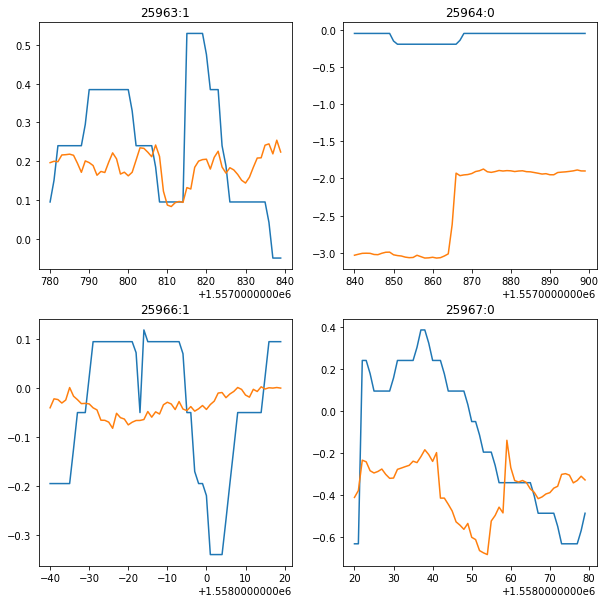

In [201]:
seqs = [25963,25964,25966,25967]
fig, axes = plt.subplots(2,2,figsize=(10,10))
axes = axes.reshape(-1)
for i, seq in enumerate(seqs):
    ax = axes[i]
    print(type(ax))
    ax.plot(train_series.loc[train_series['sequence']==seq, 'sensor_02']);
    ax.plot(train_series.loc[train_series['sequence']==seq, 'sensor_02_subject_mean']);
    ax.set_title(str(seq) + ':' + str(train_labels.loc[seq].values[0]));

<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>


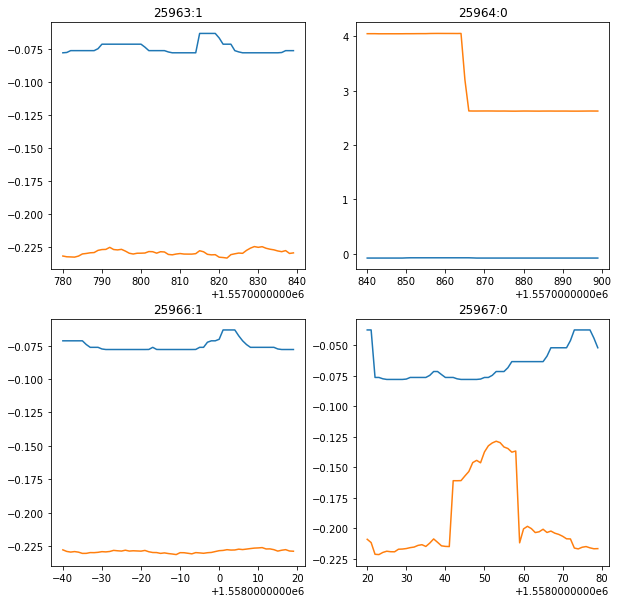

In [202]:
seqs = [25963,25964,25966,25967]
fig, axes = plt.subplots(2,2,figsize=(10,10))
axes = axes.reshape(-1)
for i, seq in enumerate(seqs):
    ax = axes[i]
    print(type(ax))
    ax.plot(train_series.loc[train_series['sequence']==seq, 'sensor_02_square']);
    ax.plot(train_series.loc[train_series['sequence']==seq, 'sensor_02_square_subject_mean']);
    ax.set_title(str(seq) + ':' + str(train_labels.loc[seq].values[0]));

In [203]:
mydataset = MyDataset(train_series, train_labels)

In [204]:
mydataset.X.shape

(25968, 78, 60)

In [205]:
class MyModel(nn.Module):
    def __init__(self, input_channel):
        super(MyModel, self).__init__()
        torch.manual_seed(123)
        self.conv1d_1 = nn.Conv1d(input_channel, 128, 3, padding='valid')
        self.maxpool_1 = nn.Conv1d(128, 128, 3, groups=128, stride=3, padding='valid')
        self.conv1d_2 = nn.Conv1d(128, 128, 3, padding='valid')
        self.maxpool_2 = nn.Conv1d(128, 128, 3, groups=128, stride=3, padding='valid')
        self.conv1d_3 = nn.Conv1d(128, 256, 3, padding='valid')
        self.maxpool_3 = nn.Conv1d(256, 256, 3, groups=256, stride=3, padding='valid')

        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 36)
        self.fc3 = nn.Linear(36, 2)
        self.dropout = nn.Dropout(p=0.3)
    
    def forward(self, X):
        ''' input shape (N,C,L) '''
        X = F.relu(self.conv1d_1(X))
        X = self.dropout(X)
        X = self.maxpool_1(X)

        X = F.relu(self.conv1d_2(X))
        X = self.dropout(X)
        X = self.maxpool_2(X)

        X = F.relu(self.conv1d_3(X))
        X = self.dropout(X)
        X = self.maxpool_3(X)
        
        X = torch.squeeze(X, dim=2)
        X = F.relu(self.fc1(X))
        X = self.dropout(X)
        X = F.relu(self.fc2(X))
        X = self.dropout(X)
        output = F.log_softmax(self.fc3(X), dim=1)
        
        return output

In [207]:
model = MyModel(78)

In [208]:
train(mydataset, weight_decay=0.0)

23371 2597
0: 0.68228904734547; test roc=0.701189908522409 test loss=0.675499439239502
1: 0.6149802229242348; test roc=0.7602117554397851 test loss=0.5938169956207275
2: 0.5662036701959708; test roc=0.7941445801425305 test loss=0.5500009059906006
3: 0.5190565110599524; test roc=0.8277512075231778 test loss=0.5040417909622192
4: 0.4775176675516254; test roc=0.8501995141439158 test loss=0.4773048758506775
5: 0.4548704015645528; test roc=0.8548884523775634 test loss=0.484159916639328
6: 0.43119086339896984; test roc=0.8722006338903597 test loss=0.44372478127479553
7: 0.4173542665229428; test roc=0.8725019215987702 test loss=0.44576478004455566
8: 0.39968064066498754; test roc=0.8829437944221444 test loss=0.42576274275779724
9: 0.38688022672433786; test roc=0.8824509399227566 test loss=0.4300955832004547
10: 0.3746447556361905; test roc=0.8929286944515614 test loss=0.42039307951927185
11: 0.36545411653978965; test roc=0.8968089598694262 test loss=0.4118368327617645
12: 0.3561427868313867; 

101: 0.12404298106437418; test roc=0.9305792789971626 test loss=0.48971083760261536
102: 0.12969326419276586; test roc=0.9282262101327563 test loss=0.5256049036979675
103: 0.12515872898776786; test roc=0.9332469800058834 test loss=0.4525427222251892
104: 0.12184382297867254; test roc=0.9308449815431624 test loss=0.4559118449687958
105: 0.12448411309516347; test roc=0.9299882687581253 test loss=0.4609782099723816
106: 0.12310494410190406; test roc=0.9281508882056536 test loss=0.4722268581390381
107: 0.12626662491431623; test roc=0.9295473092872528 test loss=0.5001408457756042
108: 0.12754718897485096; test roc=0.9313959584744879 test loss=0.5423176288604736
109: 0.12246489056657549; test roc=0.9323650610641386 test loss=0.4721502363681793
110: 0.12424530675071668; test roc=0.9318576759567663 test loss=0.47762739658355713
111: 0.1197244627104354; test roc=0.9316750054563917 test loss=0.4821756184101105
112: 0.1242315824442898; test roc=0.9302756189445914 test loss=0.49218523502349854
113

In [212]:
model = MyModel(78)
train(mydataset, weight_decay=1e-5)

23371 2597
0: 0.6823422822299988; test roc=0.6992772060428352 test loss=0.656136691570282
1: 0.6143488929164684; test roc=0.7590125354665452 test loss=0.5854508280754089
2: 0.5667002188251973; test roc=0.7972366342129984 test loss=0.5431075096130371
3: 0.5161790292499501; test roc=0.8302427619779656 test loss=0.5010560750961304
4: 0.4717808025437006; test roc=0.8511988641216158 test loss=0.48500001430511475
5: 0.45433304707804356; test roc=0.8532034949374174 test loss=0.48898640275001526
6: 0.4264860612889278; test roc=0.8735872690522959 test loss=0.4430437386035919
7: 0.4097380094384154; test roc=0.8779600924265285 test loss=0.43851980566978455
8: 0.3932093264399023; test roc=0.8849365635171424 test loss=0.4245132505893707
9: 0.3813758998845305; test roc=0.8891682324138127 test loss=0.4154329001903534
10: 0.3666845546097837; test roc=0.8919759017280154 test loss=0.416621595621109
11: 0.35815710731395517; test roc=0.8958517190005788 test loss=0.412461519241333
12: 0.34599337758615395; 

KeyboardInterrupt: 

In [215]:
class MyModel(nn.Module):
    def __init__(self, input_channel):
        super(MyModel, self).__init__()
        torch.manual_seed(123)
        self.conv1d_1 = nn.Conv1d(input_channel, 128, 3, padding='valid')
        self.maxpool_1 = nn.Conv1d(128, 128, 3, groups=128, stride=3, padding='valid')
        self.conv1d_2 = nn.Conv1d(128, 128, 3, padding='valid')
        self.maxpool_2 = nn.Conv1d(128, 128, 3, groups=128, stride=3, padding='valid')
        self.conv1d_3 = nn.Conv1d(128, 256, 3, padding='valid')
        self.maxpool_3 = nn.Conv1d(256, 256, 3, groups=256, stride=3, padding='valid')

        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 36)
        self.fc3 = nn.Linear(36, 2)
        self.dropout = nn.Dropout(p=0.5)
    
    def forward(self, X):
        ''' input shape (N,C,L) '''
        X = F.relu(self.conv1d_1(X))
        X = self.dropout(X)
        X = self.maxpool_1(X)

        X = F.relu(self.conv1d_2(X))
        X = self.dropout(X)
        X = self.maxpool_2(X)

        X = F.relu(self.conv1d_3(X))
        X = self.dropout(X)
        X = self.maxpool_3(X)
        
        X = torch.squeeze(X, dim=2)
        X = F.relu(self.fc1(X))
        X = self.dropout(X)
        X = F.relu(self.fc2(X))
        X = self.dropout(X)
        output = F.log_softmax(self.fc3(X), dim=1)
        
        return output

In [216]:
model = MyModel(78)
train(mydataset, weight_decay=1e-5)

23371 2597
0: 0.6903593177809896; test roc=0.6467671473035936 test loss=0.6842755675315857
1: 0.6535822908561366; test roc=0.7251301230772149 test loss=0.6281535029411316
2: 0.6143204634340893; test roc=0.7629165243260171 test loss=0.5867605209350586
3: 0.586400472359349; test roc=0.7875209952458222 test loss=0.5722245573997498
4: 0.5569377604727415; test roc=0.8143700002846812 test loss=0.5341998934745789
5: 0.5255254437057224; test roc=0.8164137747791348 test loss=0.5414373278617859
6: 0.5008527733059435; test roc=0.8520443082718895 test loss=0.47635045647621155
7: 0.486414729192063; test roc=0.8557955774760156 test loss=0.46527788043022156
8: 0.4754210899150712; test roc=0.8616662396447178 test loss=0.45996493101119995
9: 0.4653468787744096; test roc=0.8701749485201317 test loss=0.4434712827205658
10: 0.4531992093091405; test roc=0.8740148840872642 test loss=0.4419037103652954
11: 0.44670974802263924; test roc=0.87589971152295 test loss=0.43582773208618164
12: 0.4401398872355942; te

KeyboardInterrupt: 

### keep overfitting!

In [217]:
class MyModel(nn.Module):
    def __init__(self, input_channel):
        super(MyModel, self).__init__()
        torch.manual_seed(123)
        self.conv1d_1 = nn.Conv1d(input_channel, 78, 3, groups=78, padding='valid')
        self.maxpool_1 = nn.Conv1d(78, 78, 3, groups=78, stride=3, padding='valid')
        self.conv1d_2 = nn.Conv1d(78, 78, 3, padding='valid')
        self.maxpool_2 = nn.Conv1d(78, 78, 3, groups=78, stride=3, padding='valid')
        self.conv1d_3 = nn.Conv1d(78, 78, 3, padding='valid')
        self.maxpool_3 = nn.Conv1d(78, 78, 3, groups=78, stride=3, padding='valid')

        self.fc1 = nn.Linear(78, 36)
        self.fc2 = nn.Linear(36, 18)
        self.fc3 = nn.Linear(18, 2)
        self.dropout = nn.Dropout(p=0.3)
    
    def forward(self, X):
        ''' input shape (N,C,L) '''
        X = F.relu(self.conv1d_1(X))
        X = self.dropout(X)
        X = self.maxpool_1(X)

        X = F.relu(self.conv1d_2(X))
        X = self.dropout(X)
        X = self.maxpool_2(X)

        X = F.relu(self.conv1d_3(X))
        X = self.dropout(X)
        X = self.maxpool_3(X)
        
        X = torch.squeeze(X, dim=2)
        X = F.relu(self.fc1(X))
        X = self.dropout(X)
        X = F.relu(self.fc2(X))
        X = self.dropout(X)
        output = F.log_softmax(self.fc3(X), dim=1)
        
        return output

In [218]:
model = MyModel(78)
train(mydataset, weight_decay=1e-5)

23371 2597
0: 0.693732199951567; test roc=0.5905295428018333 test loss=0.6931391358375549
1: 0.6914361123529439; test roc=0.6168133368444028 test loss=0.6825781464576721
2: 0.6531509384943276; test roc=0.7346500436511326 test loss=0.6096652150154114
3: 0.6062369801068682; test roc=0.7688921627238305 test loss=0.5760162472724915
4: 0.5601325096699348; test roc=0.8091306782057487 test loss=0.5304887890815735
5: 0.5285315910932632; test roc=0.823610873876695 test loss=0.5271405577659607
6: 0.5131616601843587; test roc=0.8369986050616336 test loss=0.4906977117061615
7: 0.502644578009687; test roc=0.8396707542156556 test loss=0.4865030348300934
8: 0.4941163466772532; test roc=0.8548718459684381 test loss=0.4660501778125763
9: 0.48143830143958033; test roc=0.865754974805705 test loss=0.4582168459892273
10: 0.4676598564844261; test roc=0.8716555878194362 test loss=0.44481590390205383
11: 0.45984900775063275; test roc=0.8870384604435335 test loss=0.42808619141578674
12: 0.4468062789830565; tes

101: 0.28153832654842625; test roc=0.9429697360055418 test loss=0.3203314542770386
102: 0.2803114754801399; test roc=0.939795539518509 test loss=0.3325435519218445
103: 0.27977776668950194; test roc=0.9421124301344644 test loss=0.3185814917087555
104: 0.2761053964428712; test roc=0.9404977533900798 test loss=0.3253912329673767
105: 0.2761644627502827; test roc=0.9419155255691253 test loss=0.3164532780647278
106: 0.27195770247726975; test roc=0.9425646582401002 test loss=0.3142046332359314
107: 0.27558692040044697; test roc=0.9389317097009897 test loss=0.3295416831970215
108: 0.2842873337460515; test roc=0.9409443471783339 test loss=0.3179640471935272
109: 0.2755644393693569; test roc=0.9370815777986545 test loss=0.3307940363883972
110: 0.27796639663996847; test roc=0.9431473652745751 test loss=0.3161790072917938
111: 0.2767217226651956; test roc=0.941570942579782 test loss=0.3138260841369629
112: 0.2777371152360022; test roc=0.9424178694451562 test loss=0.3229072093963623
113: 0.274605

In [219]:
class MyModel(nn.Module):
    def __init__(self, input_channel):
        super(MyModel, self).__init__()
        torch.manual_seed(123)
        self.conv1d_1 = nn.Conv1d(input_channel, 78, 3, groups=78, padding='valid')
        self.bn_1 = nn.BatchNorm1d(78)
        self.maxpool_1 = nn.Conv1d(78, 78, 3, groups=78, stride=3, padding='valid')
        
        self.conv1d_2 = nn.Conv1d(78, 78, 3, padding='valid')
        self.bn_2 = nn.BatchNorm1d(78)
        self.maxpool_2 = nn.Conv1d(78, 78, 3, groups=78, stride=3, padding='valid')
        
        self.conv1d_3 = nn.Conv1d(78, 78, 3, padding='valid')
        self.bn_3 = nn.BatchNorm1d(78)
        self.maxpool_3 = nn.Conv1d(78, 78, 3, groups=78, stride=3, padding='valid')

        self.fc1 = nn.Linear(78, 36)
        self.fc2 = nn.Linear(36, 18)
        self.fc3 = nn.Linear(18, 2)
        self.dropout = nn.Dropout(p=0.3)
    
    def forward(self, X):
        ''' input shape (N,C,L) '''
        X = F.relu(self.bn_1(self.conv1d_1(X)))
        X = self.dropout(X)
        X = self.maxpool_1(X)

        X = F.relu(self.bn_2(self.conv1d_2(X)))
        X = self.dropout(X)
        X = self.maxpool_2(X)

        X = F.relu(self.bn_3(self.conv1d_3(X)))
        X = self.dropout(X)
        X = self.maxpool_3(X)
        
        X = torch.squeeze(X, dim=2)
        X = F.relu(self.fc1(X))
        X = self.dropout(X)
        X = F.relu(self.fc2(X))
        X = self.dropout(X)
        output = F.log_softmax(self.fc3(X), dim=1)
        
        return output

In [220]:
model = MyModel(78)
train(mydataset, weight_decay=1e-5)

23371 2597
0: 0.6408699060898273; test roc=0.7778750438883669 test loss=0.5974975824356079
1: 0.5663918217318207; test roc=0.7853247976390431 test loss=0.6218492388725281
2: 0.542007993047103; test roc=0.8063906207001262 test loss=0.5684854388237
3: 0.5246447291814809; test roc=0.824807128419734 test loss=0.5386093854904175
4: 0.5094803412290313; test roc=0.8335996289653733 test loss=0.5568466186523438
5: 0.4931258427832043; test roc=0.8434810354807794 test loss=0.5322950482368469
6: 0.4773893258516639; test roc=0.8578064356952392 test loss=0.5449622273445129
7: 0.4643395798619795; test roc=0.8756245196003075 test loss=0.44246602058410645
8: 0.45350596734237053; test roc=0.8841009052865317 test loss=0.4523756206035614
9: 0.4443694877484752; test roc=0.8848102361905846 test loss=0.42413032054901123
10: 0.43876043867327313; test roc=0.8895353526726829 test loss=0.44151636958122253
11: 0.4255532530141547; test roc=0.8873296656892609 test loss=0.46000078320503235
12: 0.4207969160029153; te

KeyboardInterrupt: 

In [239]:
nn.AvgPool1d?

In [252]:
class FCNModel(nn.Module):
    def __init__(self, input_channel):
        super(FCNModel, self).__init__()
        torch.manual_seed(123)
        self.conv1d_1 = nn.Conv1d(input_channel, 128, 3, padding='same')
        self.bn_1 = nn.BatchNorm1d(128)
        
        self.conv1d_2 = nn.Conv1d(128, 256, 3, padding='same')
        self.bn_2 = nn.BatchNorm1d(256)
        
        self.conv1d_3 = nn.Conv1d(256, 128, 3, padding='same')
        self.bn_3 = nn.BatchNorm1d(128)
        
        self.avg = nn.AvgPool1d(60, padding=0)
        self.fc = nn.Linear(128, 2)
    
    def forward(self, X):
        ''' input shape (N,C,L) '''
        X = F.relu(self.bn_1(self.conv1d_1(X)))
        X = F.relu(self.bn_2(self.conv1d_2(X)))
        X = F.relu(self.bn_3(self.conv1d_3(X)))

        X = self.avg(X)        
        X = torch.squeeze(X, dim=2)
        
        output = F.log_softmax(self.fc(X), dim=1)
        
        return output

In [247]:
model = FCNModel(78)

In [230]:
train_loader = DataLoader(mydataset, batch_size=1)
X, y = next(iter(train_loader))

In [245]:
nn.AvgPool1d?

In [231]:
X.shape

torch.Size([1, 78, 60])

In [253]:
model = FCNModel(78)
train(mydataset)

23371 2597
0: 0.6017311852635583; test roc=0.7577385866522428 test loss=0.5849591493606567
1: 0.5323243023385582; test roc=0.8149043708068815 test loss=0.5275160670280457
2: 0.4787378494758201; test roc=0.8431880509769314 test loss=0.582797110080719
3: 0.43579972575826986; test roc=0.8622800836963019 test loss=0.4945540428161621
4: 0.40341048304726856; test roc=0.8779079008549928 test loss=0.5072598457336426
5: 0.37711039362774545; test roc=0.8796515738131163 test loss=0.47798481583595276
6: 0.3517680241258147; test roc=0.8890982482610719 test loss=0.4534720480442047
7: 0.3302269895143775; test roc=0.9020992873478141 test loss=0.49806517362594604
8: 0.31212364444364493; test roc=0.9015287385771629 test loss=0.4100429117679596
9: 0.30286968191624564; test roc=0.9060646606124444 test loss=0.4039555788040161
10: 0.28441315238887227; test roc=0.8979915734335412 test loss=0.6320126056671143
11: 0.26840657404979823; test roc=0.9100656190394854 test loss=0.4004316031932831
12: 0.2533325605018

KeyboardInterrupt: 

In [254]:
model = FCNModel(78)
train(mydataset, batch_size=512)

23371 2597
0: 0.6271128642875807; test roc=0.7378494462948729 test loss=0.6251359581947327
1: 0.5730476450320259; test roc=0.7617282764445203 test loss=0.597283661365509
2: 0.5368575296145512; test roc=0.7850614674372041 test loss=0.6034803986549377
3: 0.5009862076975528; test roc=0.8145348782038508 test loss=0.5361289381980896
4: 0.4739572902843544; test roc=0.8201401343695732 test loss=0.5627787113189697
5: 0.43291820362506755; test roc=0.8489498818572607 test loss=0.4831540584564209
6: 0.4028008920860446; test roc=0.8561529118152229 test loss=0.49637651443481445
7: 0.37649765854765077; test roc=0.8718649471916189 test loss=0.5458855628967285
8: 0.36425509297145375; test roc=0.8716982900143291 test loss=0.5002371072769165
9: 0.33718986471266205; test roc=0.8822451390668146 test loss=0.594650149345398
10: 0.3167275947366302; test roc=0.8876926343458499 test loss=0.452087938785553
11: 0.30188573553159104; test roc=0.8719183249352349 test loss=0.7713668942451477
12: 0.278034482305089; t

100: 0.003955492213914194; test roc=0.8989482212163483 test loss=0.8486930727958679
101: 0.0024558136789849857; test roc=0.8972949938793521 test loss=1.0325603485107422
102: 0.002444273359391901; test roc=0.9000759743217468 test loss=0.863092839717865
103: 0.0019522340113718633; test roc=0.9008739715888064 test loss=0.852447509765625
104: 0.0016024652099414017; test roc=0.9004849071464495 test loss=0.8620566725730896
105: 0.0016015833707376571; test roc=0.8987332275267836 test loss=0.9209907650947571
106: 0.0016875239139690404; test roc=0.8958567602319203 test loss=1.193170189857483
107: 0.0017720498854943887; test roc=0.8995264801055218 test loss=0.8794973492622375
108: 0.0017912799649206438; test roc=0.8979847529440791 test loss=0.9014385342597961
109: 0.0012404173218184217; test roc=0.8994914880291514 test loss=0.9012336134910583
110: 0.0009972168373692451; test roc=0.8981783955361973 test loss=0.9104371666908264
111: 0.0011154753977204827; test roc=0.8993977804348032 test loss=0.91

198: 0.000983361685839041; test roc=0.901902382782475 test loss=0.9017919301986694
199: 0.000810109095737971; test roc=0.901266001461364 test loss=0.8904864192008972


In [262]:
class MyFCNModel(nn.Module):
    def __init__(self, input_channel):
        super(MyFCNModel, self).__init__()
        torch.manual_seed(123)
        
        self.conv1d_1 = nn.Conv1d(input_channel, input_channel, 5, groups=input_channel, padding='same')
        self.bn_1 = nn.BatchNorm1d(input_channel)
        self.conv1d_2 = nn.Conv1d(input_channel, input_channel, 10, groups=input_channel, padding='same')
        self.bn_2 = nn.BatchNorm1d(input_channel)
        self.conv1d_3 = nn.Conv1d(input_channel, input_channel, 60, groups=input_channel, padding='same')
        self.bn_3 = nn.BatchNorm1d(input_channel)
        
        self.conv1d_4 = nn.Conv1d(3*input_channel, 32, 3, padding='same')
        self.bn_4 = nn.BatchNorm1d(32)
        
        self.conv1d_5 = nn.Conv1d(32, 2, 3, padding='same')
        self.bn_5 = nn.BatchNorm1d(2)
        
        self.avg = nn.AvgPool1d(60, padding=0)
    
    def forward(self, X):
        ''' input shape (N,C,L) '''
        X1 = F.relu(self.bn_1(self.conv1d_1(X)))
        X2 = F.relu(self.bn_2(self.conv1d_2(X)))
        X3 = F.relu(self.bn_3(self.conv1d_3(X)))
        
        X = torch.concat([X1,X2,X3], dim=1)
        X = F.relu(self.bn_4(self.conv1d_4(X)))
        X = F.relu(self.bn_5(self.conv1d_5(X)))
        
        X = self.avg(X).squeeze(dim=2)
        output = F.log_softmax(X, dim=1)
        
        return output

In [263]:
model = MyFCNModel(78)
train(mydataset, batch_size=512)

23371 2597
0: 0.6065927665436928; test roc=0.7917052172592782 test loss=0.5801438689231873
1: 0.5241053981905668; test roc=0.8489599643199438 test loss=0.5268104672431946
2: 0.4846124967129718; test roc=0.8691284482022376 test loss=0.49082109332084656
3: 0.4615407054664837; test roc=0.8891729771021343 test loss=0.4679117202758789
4: 0.4446993198947593; test roc=0.8914172146781678 test loss=0.4577507972717285
5: 0.4295722308029214; test roc=0.8911918419829001 test loss=0.44953349232673645
6: 0.41289558915515334; test roc=0.897538455698845 test loss=0.4348606467247009
7: 0.4003526435194321; test roc=0.906236655564096 test loss=0.41734153032302856
8: 0.38957021115124185; test roc=0.90625029654302 test loss=0.40714168548583984
9: 0.379852288243737; test roc=0.914162657405035 test loss=0.4027615785598755
10: 0.36868504702006893; test roc=0.9162123627598904 test loss=0.39194944500923157
11: 0.3587889434562293; test roc=0.9190745959897895 test loss=0.38989004492759705
12: 0.34905047735304456;

100: 0.0941336567086737; test roc=0.9671219788197114 test loss=0.26662373542785645
101: 0.09530955575880601; test roc=0.9672598713240528 test loss=0.23080433905124664
102: 0.09290980794478389; test roc=0.9674158529526196 test loss=0.22804559767246246
103: 0.09223656641115126; test roc=0.9662892860193014 test loss=0.2368839532136917
104: 0.09048511170207559; test roc=0.9669823070572494 test loss=0.24126866459846497
105: 0.0984146591258556; test roc=0.9635198707546903 test loss=0.2567807734012604
106: 0.09277786442834715; test roc=0.9636604321462122 test loss=0.2543424665927887
107: 0.10338326339763301; test roc=0.9634018466326946 test loss=0.27941781282424927
108: 0.08881656777021703; test roc=0.9682438010647081 test loss=0.22569404542446136
109: 0.08943126606825691; test roc=0.9674063635759766 test loss=0.2307773381471634
110: 0.08616724246518714; test roc=0.9657208130497907 test loss=0.24692568182945251
111: 0.08434549387164866; test roc=0.9671273165940729 test loss=0.313218891620636


KeyboardInterrupt: 

In [268]:
class MyFCNModel(nn.Module):
    def __init__(self, input_channel):
        super(MyFCNModel, self).__init__()
        torch.manual_seed(123)
        
        self.conv1d_1 = nn.Conv1d(input_channel, input_channel, 5, groups=input_channel, padding='same')
        self.bn_1 = nn.BatchNorm1d(input_channel)
        self.conv1d_2 = nn.Conv1d(input_channel, input_channel, 10, groups=input_channel, padding='same')
        self.bn_2 = nn.BatchNorm1d(input_channel)
        self.conv1d_3 = nn.Conv1d(input_channel, input_channel, 60, groups=input_channel, padding='same')
        self.bn_3 = nn.BatchNorm1d(input_channel)
        
        self.conv1d_4 = nn.Conv1d(3*input_channel, 32, 3, padding='same')
        self.bn_4 = nn.BatchNorm1d(32)
        
        self.conv1d_5 = nn.Conv1d(32, 2, 3, padding='same')
        self.bn_5 = nn.BatchNorm1d(2)
        
        self.avg = nn.AvgPool1d(60, padding=0)
        self.dropout = nn.Dropout(p=0.25)
    
    def forward(self, X):
        ''' input shape (N,C,L) '''
        
        X1 = F.relu(self.bn_1(self.conv1d_1(X)))
        X2 = F.relu(self.bn_2(self.conv1d_2(X)))
        X3 = F.relu(self.bn_3(self.conv1d_3(X)))
        
        X = torch.concat([X1,X2,X3], dim=1)
        X = self.dropout(X)
        
        X = F.relu(self.bn_4(self.conv1d_4(X)))
        X = self.dropout(X)
        
        X = F.relu(self.bn_5(self.conv1d_5(X)))
        
        X = self.avg(X).squeeze(dim=2)
        output = F.log_softmax(X, dim=1)
        
        return output

In [269]:
model = MyFCNModel(78)
train(mydataset, batch_size=512)

23371 2597
0: 0.6149594422217323; test roc=0.7828812831535096 test loss=0.5880143642425537
1: 0.5423602743145948; test roc=0.8389261346922122 test loss=0.5248234272003174
2: 0.5058211840947088; test roc=0.8579766513887703 test loss=0.4969364106655121
3: 0.48314071474743103; test roc=0.8667988062364183 test loss=0.4810815453529358
4: 0.4675248917688745; test roc=0.8751553885425267 test loss=0.4698982238769531
5: 0.4521684357955823; test roc=0.8827872197075375 test loss=0.45552965998649597
6: 0.43663806021455814; test roc=0.8960729400935652 test loss=0.4592025578022003
7: 0.424933262128874; test roc=0.8957075990928156 test loss=0.43355122208595276
8: 0.41297842850708993; test roc=0.9019261062240822 test loss=0.41790473461151123
9: 0.4007418831798161; test roc=0.90624970345698 test loss=0.4097696840763092
10: 0.3914352076592053; test roc=0.9119249437754433 test loss=0.39572370052337646
11: 0.38195836866913424; test roc=0.9206379707916987 test loss=0.39643624424934387
12: 0.373048065561399

101: 0.16429235095910658; test roc=0.9673980603714141 test loss=0.22741776704788208
102: 0.16201773845543987; test roc=0.9693760023154079 test loss=0.22245755791664124
103: 0.16146740537058848; test roc=0.9678968457312039 test loss=0.22460485994815826
104: 0.16713766147897452; test roc=0.967710023628548 test loss=0.22544071078300476
105: 0.16312172722129908; test roc=0.9674152598665794 test loss=0.22553369402885437
106: 0.15727604022547256; test roc=0.9693048319905866 test loss=0.22069457173347473
107: 0.15829871154202305; test roc=0.969143216044638 test loss=0.21997420489788055
108: 0.15480833731272586; test roc=0.9691992626754348 test loss=0.22217221558094025
109: 0.1550203102085425; test roc=0.9688185014376406 test loss=0.22142793238162994
110: 0.15516669812136552; test roc=0.9691672360292651 test loss=0.2210887223482132
111: 0.15808147089157762; test roc=0.9681999126977349 test loss=0.22696462273597717
112: 0.15742013418451567; test roc=0.9686043973771362 test loss=0.22166819870471

### so this finally has some improvements gets to about 0.97

In [270]:
model = MyModel(78)
for para in model.named_parameters():
    print(para)

('conv1d_1.weight', Parameter containing:
tensor([[[-0.2354,  0.0191, -0.2867]],

        [[ 0.2177, -0.4919,  0.4232]],

        [[-0.4196, -0.4590, -0.3648]],

        [[ 0.2615, -0.2133,  0.2161]],

        [[-0.4900, -0.3503, -0.2120]],

        [[-0.1135, -0.4404,  0.3780]],

        [[-0.1362,  0.1853,  0.4083]],

        [[ 0.1076,  0.1579,  0.5573]],

        [[-0.2604,  0.1829, -0.2569]],

        [[ 0.4126,  0.4611, -0.5323]],

        [[ 0.4929,  0.2757,  0.2516]],

        [[ 0.2377,  0.4800, -0.0762]],

        [[-0.4883, -0.1657, -0.4066]],

        [[ 0.0382, -0.1078, -0.3097]],

        [[-0.0525,  0.5470, -0.0455]],

        [[ 0.0183, -0.0900,  0.0908]],

        [[ 0.5144,  0.3530,  0.2049]],

        [[ 0.1255,  0.1361,  0.2230]],

        [[-0.0746, -0.5366, -0.3570]],

        [[ 0.4928,  0.0345, -0.4677]],

        [[ 0.0911,  0.4770, -0.5456]],

        [[-0.3887, -0.2299,  0.0232]],

        [[-0.1347, -0.0634, -0.5629]],

        [[ 0.2704,  0.5068,  0.3529]],

In [274]:
para

('fc3.bias',
 Parameter containing:
 tensor([-0.0803, -0.1175], requires_grad=True))

In [277]:
para[0], para[1].reshape()

('fc3.bias', <function Parameter.reshape>)

In [293]:
sum_size = 0
for para in model.named_parameters():
    sum_size += np.prod(para[1].shape)
    print(f"{para[0]} || {np.prod(para[1].shape)}")
print(f"total = {sum_size}")

conv1d_1.weight || 234
conv1d_1.bias || 78
bn_1.weight || 78
bn_1.bias || 78
maxpool_1.weight || 234
maxpool_1.bias || 78
conv1d_2.weight || 18252
conv1d_2.bias || 78
bn_2.weight || 78
bn_2.bias || 78
maxpool_2.weight || 234
maxpool_2.bias || 78
conv1d_3.weight || 18252
conv1d_3.bias || 78
bn_3.weight || 78
bn_3.bias || 78
maxpool_3.weight || 234
maxpool_3.bias || 78
fc1.weight || 2808
fc1.bias || 36
fc2.weight || 648
fc2.bias || 18
fc3.weight || 36
fc3.bias || 2
total = 41924


In [294]:
model = FCNModel(78)
sum_size = 0
for para in model.named_parameters():
    sum_size += np.prod(para[1].shape)
    print(f"{para[0]} || {np.prod(para[1].shape)}")
print(f"total = {sum_size}")

conv1d_1.weight || 29952
conv1d_1.bias || 128
bn_1.weight || 128
bn_1.bias || 128
conv1d_2.weight || 98304
conv1d_2.bias || 256
bn_2.weight || 256
bn_2.bias || 256
conv1d_3.weight || 98304
conv1d_3.bias || 128
bn_3.weight || 128
bn_3.bias || 128
fc.weight || 256
fc.bias || 2
total = 228354


In [295]:
model = MyFCNModel(78)
sum_size = 0
for para in model.named_parameters():
    sum_size += np.prod(para[1].shape)
    print(f"{para[0]} || {np.prod(para[1].shape)}")
print(f"total = {sum_size}")

conv1d_1.weight || 390
conv1d_1.bias || 78
bn_1.weight || 78
bn_1.bias || 78
conv1d_2.weight || 780
conv1d_2.bias || 78
bn_2.weight || 78
bn_2.bias || 78
conv1d_3.weight || 4680
conv1d_3.bias || 78
bn_3.weight || 78
bn_3.bias || 78
conv1d_4.weight || 22464
conv1d_4.bias || 32
bn_4.weight || 32
bn_4.bias || 32
conv1d_5.weight || 192
conv1d_5.bias || 2
bn_5.weight || 2
bn_5.bias || 2
total = 29310


#### the simplest model is in fact the most effective

### the subject mean stuffs are still bothersome, let's make sure they're okay

In [352]:
roc_auc_score?

In [299]:
train_series = pd.read_csv('train.csv')
train_labels = pd.read_csv('train_labels.csv', index_col=['sequence'])

In [301]:
train_series['subject']

0           47
1           47
2           47
3           47
4           47
          ... 
1558075    327
1558076    327
1558077    327
1558078    327
1558079    327
Name: subject, Length: 1558080, dtype: int64

In [302]:
subjects = train_series['subject'].unique()
subjects

array([ 47,  66, 542, 437, 510, 246, 520,  78, 526,   4, 508, 651, 123,
       100,  99, 381, 511, 263, 543, 239, 317, 489,  48, 357, 333, 232,
       623, 661, 290, 582, 465, 207, 443, 394, 573, 579, 365,  35,  82,
       164, 322, 235, 138,  89,  70,  76, 346, 662, 107, 505, 479, 140,
       188,  59, 441, 596, 671, 426, 191, 330, 597, 392, 120, 297, 415,
       416, 420,  60, 438,  98, 487, 665, 358, 103, 590, 122, 256, 535,
       127, 146, 473,  71,  88,  41,  56, 352,  38, 198, 468, 460, 558,
       203, 196, 311, 496, 131, 491,  75, 408, 285, 422, 583, 553, 364,
       499, 141, 424, 229, 351, 374, 530, 598, 607, 222, 647, 310, 395,
       630, 476, 189, 454, 213, 431, 318, 166, 249,  42, 369, 125, 309,
       538, 197, 251,  44, 622,  72, 337, 209, 477, 359, 555,   2,  94,
       269,  52, 397, 480, 240, 185,  95, 559, 502, 386, 258, 545, 450,
        40, 463, 170, 294, 413, 667, 306, 341,  25,   1, 262, 646, 272,
       237, 613, 640,  91, 266, 338,   0, 144, 563, 417,  18, 10

In [305]:
train_subjects, test_subjects = train_test_split(subjects, test_size=0.1)

In [306]:
train_subjects, test_subjects

(array([562,  99, 122, 624, 251, 343, 563, 128, 477,  80, 319, 183, 302,
         28, 528, 340, 635,  59, 447, 242, 139, 619,  54, 250, 429, 458,
        375, 184,  92, 519, 297, 129, 371,  82, 531, 391, 493, 313,  78,
         74, 108, 173, 392, 537, 569, 101, 174,  11, 333, 515, 370,  66,
        142, 218, 235,  55, 445, 541, 516,  34, 638, 538, 670, 212, 402,
        160, 301, 549, 601, 281,  41, 439, 209, 344, 403, 426, 217,  16,
        269,  81,   2, 310, 542, 404, 658, 486, 337, 234, 501, 264, 472,
        533, 125, 320,  19, 603, 284,  21,  13, 180, 298, 608, 171, 161,
        661, 130, 451, 164, 559, 379, 420, 525, 324, 434, 465, 639,  48,
        275, 452, 581, 664, 455, 657, 123,  37, 158, 221, 592,   5, 118,
        561, 631, 644, 355,  72, 145,  51, 442, 505, 427, 278, 322, 231,
        380, 220, 162, 233, 412, 556, 546, 137, 494, 127, 609, 100, 246,
        258, 393, 299, 524, 495, 560,   1, 530, 600, 132, 383, 643, 642,
        474,   8, 293,  43, 667, 244, 245, 430, 419

In [311]:
train_series.loc[train_series['subject'].isin(train_subjects)]

,sequence,subject,step,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12
0,0,47,0,-0.196291,0.112395,1.000000,0.329204,-1.004660,-0.131638,-0.127505,0.368702,-0.1,-0.963873,-0.985069,0.531893,4.751492
1,0,47,1,-0.447450,0.134454,1.000000,-0.658407,0.162495,0.340314,-0.209472,-0.867176,0.2,-0.301301,0.082733,-0.231481,0.454390
2,0,47,2,0.326893,-0.694328,1.000000,0.330088,0.473678,1.280479,-0.094718,0.535878,1.4,1.002168,0.449221,-0.586420,-4.736147
3,0,47,3,0.523184,0.751050,1.000000,0.976991,-0.563287,-0.720269,0.793260,0.951145,-0.3,-0.995665,-0.434290,1.344650,0.429241
4,0,47,4,0.272025,1.074580,1.000000,-0.136283,0.398579,0.044877,0.560109,-0.541985,-0.9,1.055636,0.812631,0.123457,-0.223359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1558075,25967,327,55,-0.282844,-1.217437,-1.666153,0.586726,-0.930698,-0.451010,-0.651184,0.368702,0.4,0.008671,-0.723536,-0.353909,-0.914749
1558076,25967,327,56,0.130603,0.349790,-1.666153,-0.324779,0.775324,-0.332835,0.099271,0.122137,-0.2,0.644509,0.691407,-0.613169,-0.515772
1558077,25967,327,57,-0.579598,0.429622,-1.666153,0.319469,0.308861,0.282723,-0.512750,0.012214,-1.6,-0.424133,0.716855,1.628601,0.928389
1558078,25967,327,58,1.278980,1.711134,-1.522820,0.802655,-0.460541,-0.055348,2.405282,0.043511,1.9,0.283960,-0.914914,0.364198,0.211424


In [313]:
def prep_withsubject(df):
    scs = {}
    for col in df.columns[3:]:
        sc = StandardScaler()
        train_series[col] = sc.fit_transform(train_series[col].values.reshape(-1,1))
        scs[col] = sc
    
    for sensor in df.columns[3:]:
        df[sensor+'_square'] = np.square(df[sensor])
        df[sensor+'_diff'] = df[sensor].diff()
        df.loc[df['step']==0, sensor+'_diff'] = 0.0
        
        tmp = df.groupby(['subject','step']).agg({sensor:'mean'}).to_dict()[sensor]
        df[sensor+'_subject_mean'] = pd.Series(zip(df['subject'], df['step'])).map(tmp)
        
        tmp = df.groupby(['subject','step']).agg({sensor+'_square':'mean'}).to_dict()[sensor+'_square']
        df[sensor+'_square_subject_mean'] = pd.Series(zip(df['subject'], df['step'])).map(tmp)
        
        tmp = df.groupby(['subject','step']).agg({sensor+'_diff':'mean'}).to_dict()[sensor+'_diff']
        df[sensor+'_diff_subject_mean'] = pd.Series(zip(df['subject'], df['step'])).map(tmp)
    
    for col in df.columns[16:]:
        sc = StandardScaler()
        train_series[col] = sc.fit_transform(train_series[col].values.reshape(-1,1))
        scs[col] = sc
    
    return scs

In [314]:
scs = prep_withsubject(train_series)

In [315]:
scs

{'sensor_00': StandardScaler(),
 'sensor_01': StandardScaler(),
 'sensor_02': StandardScaler(),
 'sensor_03': StandardScaler(),
 'sensor_04': StandardScaler(),
 'sensor_05': StandardScaler(),
 'sensor_06': StandardScaler(),
 'sensor_07': StandardScaler(),
 'sensor_08': StandardScaler(),
 'sensor_09': StandardScaler(),
 'sensor_10': StandardScaler(),
 'sensor_11': StandardScaler(),
 'sensor_12': StandardScaler(),
 'sensor_00_square': StandardScaler(),
 'sensor_00_diff': StandardScaler(),
 'sensor_00_subject_mean': StandardScaler(),
 'sensor_00_square_subject_mean': StandardScaler(),
 'sensor_00_diff_subject_mean': StandardScaler(),
 'sensor_01_square': StandardScaler(),
 'sensor_01_diff': StandardScaler(),
 'sensor_01_subject_mean': StandardScaler(),
 'sensor_01_square_subject_mean': StandardScaler(),
 'sensor_01_diff_subject_mean': StandardScaler(),
 'sensor_02_square': StandardScaler(),
 'sensor_02_diff': StandardScaler(),
 'sensor_02_subject_mean': StandardScaler(),
 'sensor_02_squar

In [316]:
train_series

,sequence,subject,step,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,...,sensor_11_square,sensor_11_diff,sensor_11_subject_mean,sensor_11_square_subject_mean,sensor_11_diff_subject_mean,sensor_12_square,sensor_12_diff,sensor_12_subject_mean,sensor_12_square_subject_mean,sensor_12_diff_subject_mean
0,0,47,0,-0.073994,0.025755,0.529941,0.084226,-0.595617,-0.081710,-0.037993,...,-0.025588,0.000004,0.169520,-0.020093,0.000023,-0.175663,0.000028,-0.329486,-0.196855,0.000185
1,0,47,1,-0.168462,0.030764,0.529941,-0.166807,0.097598,0.214962,-0.062496,...,-0.025885,-0.107653,-1.902233,1.199492,-1.336326,-0.178282,-0.090555,-0.550292,-0.249333,-0.180399
2,0,47,2,0.122789,-0.157416,0.529941,0.084451,0.282421,0.805957,-0.028192,...,-0.025522,-0.050052,-0.571634,-0.065638,0.858303,-0.175706,-0.109388,0.132766,-0.228505,0.558820
3,0,47,3,0.196619,0.170766,0.529941,0.248882,-0.333470,-0.451728,0.237261,...,-0.023654,0.272336,0.693030,-0.046261,0.815772,-0.178285,0.108915,0.339801,-0.236604,0.169508
4,0,47,4,0.102151,0.244225,0.529941,-0.034093,0.237816,0.029248,0.167563,...,-0.025930,-0.172217,1.853224,0.535110,0.748386,-0.178302,-0.013728,-0.110730,-0.240130,-0.368278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1558075,25967,327,55,-0.106549,-0.276191,-0.630265,0.149683,-0.551688,-0.282470,-0.194542,...,-0.025796,0.052816,-0.430409,-0.134037,-0.479025,-0.178212,-0.032742,-0.054692,-0.291092,-0.056322
1558076,25967,327,56,0.048959,0.079657,-0.630265,-0.082005,0.461579,-0.208184,0.029800,...,-0.025481,-0.036559,-0.268016,-0.133964,0.104772,-0.178278,0.008439,0.000476,-0.291084,0.045304
1558077,25967,327,57,-0.218166,0.097783,-0.630265,0.081752,0.184530,0.178760,-0.153159,...,-0.022585,0.316153,0.166256,-0.134396,0.280143,-0.178204,0.030471,-0.038423,-0.291092,-0.031628
1558078,25967,327,58,0.480893,0.388758,-0.567891,0.204569,-0.272446,-0.033754,0.719161,...,-0.025780,-0.178311,0.261708,-0.135871,0.061592,-0.178301,-0.015085,0.079574,-0.290859,0.096688


In [317]:
subjects

array([ 47,  66, 542, 437, 510, 246, 520,  78, 526,   4, 508, 651, 123,
       100,  99, 381, 511, 263, 543, 239, 317, 489,  48, 357, 333, 232,
       623, 661, 290, 582, 465, 207, 443, 394, 573, 579, 365,  35,  82,
       164, 322, 235, 138,  89,  70,  76, 346, 662, 107, 505, 479, 140,
       188,  59, 441, 596, 671, 426, 191, 330, 597, 392, 120, 297, 415,
       416, 420,  60, 438,  98, 487, 665, 358, 103, 590, 122, 256, 535,
       127, 146, 473,  71,  88,  41,  56, 352,  38, 198, 468, 460, 558,
       203, 196, 311, 496, 131, 491,  75, 408, 285, 422, 583, 553, 364,
       499, 141, 424, 229, 351, 374, 530, 598, 607, 222, 647, 310, 395,
       630, 476, 189, 454, 213, 431, 318, 166, 249,  42, 369, 125, 309,
       538, 197, 251,  44, 622,  72, 337, 209, 477, 359, 555,   2,  94,
       269,  52, 397, 480, 240, 185,  95, 559, 502, 386, 258, 545, 450,
        40, 463, 170, 294, 413, 667, 306, 341,  25,   1, 262, 646, 272,
       237, 613, 640,  91, 266, 338,   0, 144, 563, 417,  18, 10

In [319]:
mydataset[0]

(tensor([[-7.3994e-02, -1.6846e-01,  1.2279e-01,  ...,  3.6637e-01,
          -2.1194e+00,  2.8336e+00],
         [ 2.5755e-02,  3.0764e-02, -1.5742e-01,  ..., -5.8768e-01,
           8.2307e-01, -4.0689e-01],
         [ 5.2994e-01,  5.2994e-01,  5.2994e-01,  ...,  3.8489e-01,
           3.8489e-01,  3.8489e-01],
         ...,
         [-3.2949e-01, -5.5029e-01,  1.3277e-01,  ..., -3.9417e-02,
          -6.9567e-02, -1.8262e-01],
         [-1.9685e-01, -2.4932e-01, -2.2851e-01,  ..., -2.3328e-01,
          -2.0985e-01, -2.1715e-01],
         [ 1.8535e-04, -1.8040e-01,  5.5882e-01,  ..., -5.1834e-03,
          -2.4473e-02, -9.2277e-02]]),
 tensor(0))

In [336]:
tmp['sequence'].unique()

array([    0,     1,     2, ..., 25965, 25966, 25967])

In [334]:
train_labels

,state
sequence,
0,0
1,1
2,1
3,1
4,1
...,...
25963,1
25964,0
25965,1


In [342]:
train_labels = pd.read_csv('train_labels.csv')

In [343]:
def train(series, labels, weight_decay=1e-4, epoches=200, batch_size=64):
    torch.manual_seed(123)
    np.random.seed(123)
    
    train_subjects, test_subjects = train_test_split(subjects, test_size=0.1)
    train_series = series.loc[series['subject'].isin(train_subjects)]
    test_series = series.loc[series['subject'].isin(test_subjects)]
    
    train_seqs = train_series['sequence'].unique()
    test_seqs = test_series['sequence'].unique()
    
    train_labels = labels.loc[labels['sequence'].isin(train_seqs)]
    test_labels = labels.loc[labels['sequence'].isin(test_seqs)]
    train_dataset = MyDataset(train_series, train_labels)
    test_dataset = MyDataset(test_series, test_labels)
    
    train_loader = DataLoader(train_dataset, shuffle=True, drop_last=False, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, shuffle=False, drop_last=False, 
                             batch_size=len(test_dataset))
    
    criteria = nn.NLLLoss()
    optimizer = torch.optim.Adam(model.parameters(), weight_decay=weight_decay)
    
    for epoch in range(epoches):
        
        curr_loss = 0.0
        model.train()
        
        for batch, (X, y) in enumerate(train_loader):
            output = model(X)
            loss = criteria(output, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            curr_loss += loss.item() * len(y)
        
        curr_loss /= len(train_loader.dataset)
        score, test_loss = evaluate(test_loader)
        print(f"{epoch}: {curr_loss}; test roc={score} test loss={test_loss}")

In [344]:
model = MyFCNModel(78)
train(train_series, train_labels, batch_size=512)

0: 0.6148924651431992; test roc=0.7863969139113074 test loss=0.5921301245689392
1: 0.5425890751101913; test roc=0.8424835819995392 test loss=0.5290693640708923
2: 0.5045797857461721; test roc=0.8614340146076589 test loss=0.5010915994644165
3: 0.4839936602650193; test roc=0.8667697301395504 test loss=0.49820587038993835
4: 0.4661319978436099; test roc=0.8860141682659274 test loss=0.4710712134838104
5: 0.45136187311349907; test roc=0.8918652011622372 test loss=0.4525001347064972
6: 0.4354365152097761; test roc=0.8944143259304251 test loss=0.44315895438194275
7: 0.4265470668925534; test roc=0.8953329585570684 test loss=0.4415406882762909
8: 0.41469812575180537; test roc=0.904695365051467 test loss=0.42724037170410156
9: 0.4060038010332349; test roc=0.8998849286094293 test loss=0.42225751280784607
10: 0.39422597693956807; test roc=0.9046673645259188 test loss=0.41422098875045776
11: 0.3893567333470453; test roc=0.9140114629843822 test loss=0.40141260623931885
12: 0.3779934542673244; test r

101: 0.16098115710515074; test roc=0.9707922210232254 test loss=0.22515985369682312
102: 0.1594468268979492; test roc=0.9707798361753867 test loss=0.21649368107318878
103: 0.15784390227424352; test roc=0.9704174447581939 test loss=0.22816234827041626
104: 0.15845631606908592; test roc=0.970461060961452 test loss=0.22205445170402527
105: 0.15834561270375605; test roc=0.967535544513297 test loss=0.22870472073554993
106: 0.155125189139556; test roc=0.9689431093937455 test loss=0.23285676538944244
107: 0.15850677473227928; test roc=0.9702677496408395 test loss=0.23297753930091858
108: 0.15979354880378563; test roc=0.9702429799451621 test loss=0.23501668870449066
109: 0.15771444954929384; test roc=0.9705940634578064 test loss=0.21657639741897583
110: 0.15822884832493753; test roc=0.9653611960101406 test loss=0.23591876029968262
111: 0.15815409404208935; test roc=0.9669071481033952 test loss=0.235129252076149
112: 0.15556912855139163; test roc=0.969240345741874 test loss=0.22844967246055603


KeyboardInterrupt: 

In [345]:
train_series = pd.read_csv('train.csv')
train_labels = pd.read_csv('train_labels.csv')

In [346]:
def prep_nosubject(df):
    scs = {}
    for col in df.columns[3:]:
        sc = StandardScaler()
        train_series[col] = sc.fit_transform(train_series[col].values.reshape(-1,1))
        scs[col] = sc
    
    for sensor in df.columns[3:]:
        df[sensor+'_square'] = np.square(df[sensor])
        df[sensor+'_diff'] = df[sensor].diff()
        df.loc[df['step']==0, sensor+'_diff'] = 0.0
    
    for col in df.columns[16:]:
        sc = StandardScaler()
        train_series[col] = sc.fit_transform(train_series[col].values.reshape(-1,1))
        scs[col] = sc
    
    return scs

In [347]:
scs = prep_nosubject(train_series)

In [348]:
train_series

,sequence,subject,step,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,...,sensor_08_square,sensor_08_diff,sensor_09_square,sensor_09_diff,sensor_10_square,sensor_10_diff,sensor_11_square,sensor_11_diff,sensor_12_square,sensor_12_diff
0,0,47,0,-0.073994,0.025755,0.529941,0.084226,-0.595617,-0.081710,-0.037993,...,-0.018119,-0.000123,-0.019369,0.000112,-0.114782,-0.000028,-0.025588,0.000004,-0.175663,0.000028
1,0,47,1,-0.168462,0.030764,0.529941,-0.166807,0.097598,0.214962,-0.062496,...,-0.018093,0.039385,-0.022178,0.162931,-0.155695,0.483414,-0.025885,-0.107653,-0.178282,-0.090555
2,0,47,2,0.122789,-0.157416,0.529941,0.084451,0.282421,0.805957,-0.028192,...,-0.016375,0.157911,-0.019135,0.320423,-0.147434,0.165898,-0.025522,-0.050052,-0.175706,-0.109388
3,0,47,3,0.196619,0.170766,0.529941,0.248882,-0.333470,-0.451728,0.237261,...,-0.018048,-0.224005,-0.019160,-0.490831,-0.147968,-0.400034,-0.023654,0.272336,-0.178285,0.108915
4,0,47,4,0.102151,0.244225,0.529941,-0.034093,0.237816,0.029248,0.167563,...,-0.017404,-0.079140,-0.018768,0.504194,-0.127986,0.564510,-0.025930,-0.172217,-0.178302,-0.013728
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1558075,25967,327,55,-0.106549,-0.276191,-0.630265,0.149683,-0.551688,-0.282470,-0.194542,...,-0.017985,0.210589,-0.022485,0.161333,-0.133750,-0.057319,-0.025796,0.052816,-0.178212,-0.032742
1558076,25967,327,56,0.048959,0.079657,-0.630265,-0.082005,0.461579,-0.208184,0.029800,...,-0.018093,-0.079140,-0.021101,0.156361,-0.135719,0.640581,-0.025481,-0.036559,-0.178278,0.008439
1558077,25967,327,57,-0.218166,0.097783,-0.630265,0.081752,0.184530,0.178760,-0.153159,...,-0.015839,-0.184496,-0.021879,-0.262494,-0.134199,0.011493,-0.022585,0.316153,-0.178204,0.030471
1558078,25967,327,58,0.480893,0.388758,-0.567891,0.204569,-0.272446,-0.033754,0.719161,...,-0.014898,0.460810,-0.022218,0.174117,-0.120440,-0.738804,-0.025780,-0.178311,-0.178301,-0.015085


In [349]:
model = MyFCNModel(39)
train(train_series, train_labels, batch_size=512)

0: 0.6556498732081316; test roc=0.757476678793048 test loss=0.6179081201553345
1: 0.5851236249471268; test roc=0.8046317177030092 test loss=0.5577724575996399
2: 0.5489810067635578; test roc=0.8218563486883907 test loss=0.5425735712051392
3: 0.527179610366516; test roc=0.8397239148180935 test loss=0.5162093639373779
4: 0.5113109986035227; test roc=0.8470164363084968 test loss=0.5090605020523071
5: 0.49497218960435624; test roc=0.8646982297206193 test loss=0.4955395460128784
6: 0.4817498244501337; test roc=0.8523844601390981 test loss=0.49347975850105286
7: 0.47275979660251655; test roc=0.8779629402274934 test loss=0.4603789448738098
8: 0.4609949028665886; test roc=0.8706526491727999 test loss=0.4708009660243988
9: 0.44922436099867713; test roc=0.8773641597580755 test loss=0.4572412073612213
10: 0.43996873384714896; test roc=0.8798233597615215 test loss=0.4452902376651764
11: 0.42882044932392543; test roc=0.8990753364909311 test loss=0.41899028420448303
12: 0.41720515925256213; test roc

101: 0.22889037899374476; test roc=0.9644011010668201 test loss=0.2420780509710312
102: 0.22657684015302756; test roc=0.9663062137473964 test loss=0.234933540225029
103: 0.22493617377116204; test roc=0.9632336945401129 test loss=0.28546950221061707
104: 0.22407478808602557; test roc=0.9680960934959086 test loss=0.22980165481567383
105: 0.22355949293021907; test roc=0.9670466122594916 test loss=0.2346179336309433
106: 0.22087976688022698; test roc=0.9653983505536564 test loss=0.26896393299102783
107: 0.22831652395649427; test roc=0.9658652054700103 test loss=0.25495290756225586
108: 0.22235819399703127; test roc=0.9655378147097531 test loss=0.2617090344429016
109: 0.2209458845514959; test roc=0.9666812592482505 test loss=0.23990291357040405
110: 0.21854763255167753; test roc=0.9621400586287927 test loss=0.2492721825838089
111: 0.2235508736367428; test roc=0.9638739373262084 test loss=0.2628619372844696
112: 0.2195450118533068; test roc=0.9639008609084662 test loss=0.2858622074127197
113

### so the subject features are fine

In [350]:
train_series.tail()

,sequence,subject,step,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,...,sensor_08_square,sensor_08_diff,sensor_09_square,sensor_09_diff,sensor_10_square,sensor_10_diff,sensor_11_square,sensor_11_diff,sensor_12_square,sensor_12_diff
1558075,25967,327,55,-0.106549,-0.276191,-0.630265,0.149683,-0.551688,-0.282470,-0.194542,...,-0.017985,0.210589,-0.022485,0.161333,-0.133750,-0.057319,-0.025796,0.052816,-0.178212,-0.032742
1558076,25967,327,56,0.048959,0.079657,-0.630265,-0.082005,0.461579,-0.208184,0.029800,...,-0.018093,-0.079140,-0.021101,0.156361,-0.135719,0.640581,-0.025481,-0.036559,-0.178278,0.008439
1558077,25967,327,57,-0.218166,0.097783,-0.630265,0.081752,0.184530,0.178760,-0.153159,...,-0.015839,-0.184496,-0.021879,-0.262494,-0.134199,0.011493,-0.022585,0.316153,-0.178204,0.030471
1558078,25967,327,58,0.480893,0.388758,-0.567891,0.204569,-0.272446,-0.033754,0.719161,...,-0.014898,0.460810,-0.022218,0.174117,-0.120440,-0.738804,-0.025780,-0.178311,-0.178301,-0.015085
1558079,25967,327,59,-0.427448,-0.840493,-0.485211,-0.194250,-0.254322,-0.056792,-0.751041,...,-0.017046,-0.395209,-0.021049,-0.230356,-0.148540,0.224714,-0.023295,-0.256369,-0.178027,-0.037342


In [351]:
model.state_dict()